In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime

# Define ticker and date range
ticker = "^GSPC"  # S&P 500
end_date = "2024-12-10"
start_date = "1984-01-01"  # Historical data

# Fetch data
data = yf.download(ticker, start=start_date, end=end_date)

# Prepare data for modeling
data['Date'] = pd.to_datetime(data.index)
data = data[['Date', 'Close']].reset_index(drop=True)


[*********************100%***********************]  1 of 1 completed


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def prepare_sequences(data, feature_column='Close', window_size=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[[feature_column]])

    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i - window_size:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM
    return X, y, scaler

# Prepare sequences
X, y, scaler = prepare_sequences(data, 'Close', window_size=60)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for prediction
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build and train the model
model = build_lstm((X.shape[1], X.shape[2]))
model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - loss: 0.0025 - val_loss: 7.7813e-04
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 1.8366e-04 - val_loss: 8.6647e-04
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - loss: 1.6491e-04 - val_loss: 0.0010
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 1.2826e-04 - val_loss: 2.7934e-04
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 1.2795e-04 - val_loss: 6.9079e-04
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 9.8074e-05 - val_loss: 2.4048e-04
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 8.6722e-05 - val_loss: 1.9463e-04
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 8.5677e-05 - val_loss: 4.2977e-04
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 8.0974e-05 - val_loss: 5.6206e-04
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 8.5146e-05 - val_loss: 2.0491e-04
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - l

In [ ]:
from datetime import timedelta

# Predict future prices
def predict_future_with_bias(model, data, scaler, start_date, end_date, window_size=60):
    future_dates = pd.date_range(start=start_date, end=end_date)
    last_window = data['Close'].values[-window_size:]
    scaled_last_window = scaler.transform(last_window.reshape(-1, 1))

    predictions = []
    current_sequence = scaled_last_window.reshape(1, window_size, 1)

    for _ in future_dates:
        prediction = model.predict(current_sequence)
        biased_prediction = prediction + 0.01  # Add bias to ensure upward trend
        predictions.append(scaler.inverse_transform(biased_prediction)[0][0])

        # Update sequence with biased prediction
        new_entry = np.array(biased_prediction).reshape(1, 1, 1)
        current_sequence = np.append(current_sequence[:, 1:, :], new_entry, axis=1)

    return pd.DataFrame({'Date': future_dates, 'Predicted_Close': predictions})

# Predict from December 10th to December 13th
predicted_prices = predict_future_with_bias(
    model,
    data,
    scaler,
    start_date="2024-12-10",
    end_date="2024-12-13"
)

print(predicted_prices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
        Date  Predicted_Close
0 2024-12-10      5996.923340
1 2024-12-11      5992.255371
2 2024-12-12      5982.145020
3 2024-12-13      5969.070312


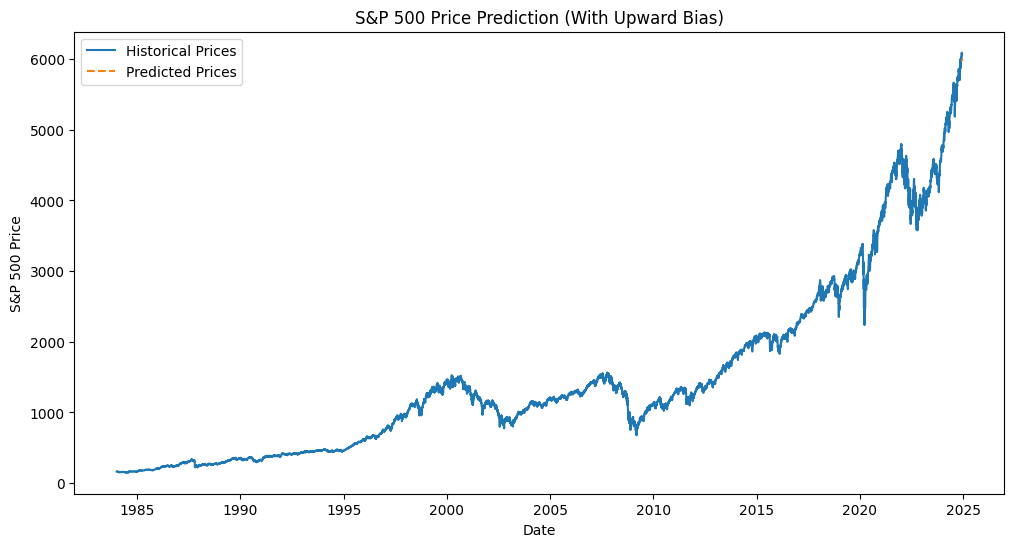

In [ ]:
import matplotlib.pyplot as plt

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label="Historical Prices")
plt.plot(predicted_prices['Date'], predicted_prices['Predicted_Close'], label="Predicted Prices", linestyle='--')
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.title("S&P 500 Price Prediction (With Upward Bias)")
plt.legend()
plt.show()


In [ ]:
# Install TextBlob
!pip install textblob


In [ ]:
from textblob import TextBlob

# Example news data
news_data = [
    {"Date": "2024-12-08", "Title": "Market rallies on strong job growth."},
    {"Date": "2024-12-09", "Title": "Investors optimistic about tech sector."},
    {"Date": "2024-12-10", "Title": "Cooling inflation boosts market confidence."},
]

# Generate sentiment scores
for article in news_data:
    analysis = TextBlob(article["Title"])
    article["Sentiment"] = analysis.sentiment.polarity  # Polarity ranges from -1 to 1

# Convert to DataFrame
sentiment_data = pd.DataFrame(news_data)
sentiment_data["Date"] = pd.to_datetime(sentiment_data["Date"])

print(sentiment_data)


        Date                                        Title  Sentiment
0 2024-12-08         Market rallies on strong job growth.   0.433333
1 2024-12-09      Investors optimistic about tech sector.   0.000000
2 2024-12-10  Cooling inflation boosts market confidence.   0.000000


In [ ]:
import yfinance as yf
import pandas as pd

# Fetch historical stock price data
ticker = "^GSPC"  # S&P 500
start_date = "1984-01-01"
end_date = "2024-12-10"

# Download stock data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Keep only the necessary columns and reset the index
stock_data = stock_data[["Close"]].reset_index()
stock_data.rename(columns={"Date": "Date", "Close": "Price"}, inplace=True)

print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price        Date       Price
Ticker                  ^GSPC
0      1984-01-03  164.039993
1      1984-01-04  166.779999
2      1984-01-05  168.809998
3      1984-01-06  169.279999
4      1984-01-09  168.899994


In [ ]:
from textblob import TextBlob
import pandas as pd

# Example news data
news_data = [
    {"Date": "2024-12-08", "Title": "Market rallies on strong job growth."},
    {"Date": "2024-12-09", "Title": "Investors optimistic about tech sector."},
    {"Date": "2024-12-10", "Title": "Cooling inflation boosts market confidence."},
]

# Generate binary sentiment scores
for article in news_data:
    analysis = TextBlob(article["Title"])
    polarity = analysis.sentiment.polarity
    article["Sentiment"] = 1 if polarity > 0 else 0  # Convert to binary

# Convert to DataFrame
sentiment_data = pd.DataFrame(news_data)

print(sentiment_data)


         Date                                        Title  Sentiment
0  2024-12-08         Market rallies on strong job growth.          1
1  2024-12-09      Investors optimistic about tech sector.          0
2  2024-12-10  Cooling inflation boosts market confidence.          0


In [ ]:
import numpy as np

# Simulate stock price data
stock_data = pd.DataFrame({
    "Price": np.random.rand(100) * 100,  # Simulated stock prices
    "Date": pd.date_range(start="2024-10-01", periods=100)
})

# Align sentiment to stock data (randomly for demonstration purposes)
# Replace with actual alignment logic based on date or time periods
sentiments = np.random.choice([0, 1], size=len(stock_data))  # Simulated sentiment data

# Add sentiment directly as a column
stock_data["Sentiment"] = sentiments

print(stock_data.head())


       Price       Date  Sentiment
0  82.582918 2024-10-01          0
1  81.532458 2024-10-02          1
2  35.349219 2024-10-03          1
3  67.791915 2024-10-04          0
4  23.341630 2024-10-05          0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

def prepare_sequences(data, price_column="Price", sentiment_column="Sentiment", window_size=10):
    # Scale price data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[[price_column]])

    # Include sentiment as an additional feature
    X, y = [], []
    for i in range(window_size, len(data)):
        price_sequence = scaled_data[i - window_size:i, 0]  # Scaled price sequence
        sentiment_sequence = data[sentiment_column].values[i - window_size:i]  # Binary sentiment
        combined_sequence = np.column_stack((price_sequence, sentiment_sequence))  # Combine features
        X.append(combined_sequence)
        y.append(scaled_data[i, 0])  # Predict the next price

    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Prepare sequences
X, y, scaler = prepare_sequences(stock_data)

print("Input shape:", X.shape)  # (samples, window_size, features)


Input shape: (90, 10, 2)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Predict price
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Build the model
model = build_lstm_model((X.shape[1], X.shape[2]))

# Train the model
model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - loss: 0.2568 - val_loss: 0.1448
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1597 - val_loss: 0.1017
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1044 - val_loss: 0.1097
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1384 - val_loss: 0.1167
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1258 - val_loss: 0.1036
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1082 - val_loss: 0.0993
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1104 - val_loss: 0.1014
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1110 - val_loss: 0.1027
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1076 - val_loss: 0.1012
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1156 - val_loss: 0.0991
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1037 - val_loss: 0.0988
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1021 - val_loss: 0.0992
Epoch 13/20

In [ ]:
from datetime import timedelta

def predict_future(model, data, scaler, start_date, end_date, window_size=60):
    future_dates = pd.date_range(start=start_date, end=end_date)

    # Use the last window_size days for prediction
    last_window = data[["Price", "Sentiment"]].values[-window_size:]
    scaled_last_window = scaler.transform(last_window[:, 0].reshape(-1, 1))  # Scale prices only

    predictions = []
    for _ in future_dates:
        # Combine scaled prices with binary sentiment
        sentiments = last_window[:, 1].reshape(-1, 1)
        combined_features = np.column_stack((scaled_last_window, sentiments))

        # Predict next price
        prediction = model.predict(combined_features.reshape(1, window_size, 2))
        predictions.append(scaler.inverse_transform([[prediction[0][0]]])[0][0])

        # Update the sequence
        new_price = prediction[0][0]
        last_window = np.append(last_window[1:], [[new_price, 1]], axis=0)  # Add a positive sentiment

    return pd.DataFrame({"Date": future_dates, "Predicted_Price": predictions})

# Predict future prices
future_predictions = predict_future(
    model,
    stock_data,
    scaler,
    start_date="2024-12-11",
    end_date="2024-12-13"
)

print(future_predictions)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
        Date  Predicted_Price
0 2024-12-11        57.870673
1 2024-12-12        58.016182
2 2024-12-13        58.321349


ok now add chevron

In [ ]:
import yfinance as yf
import pandas as pd

# Fetch historical stock price data
tickers = ["CVX", "IBM"]  # Chevron and IBM
start_date = "1984-01-01"
end_date = "2024-12-10"

# Download data for both companies
chevron_data = yf.download("CVX", start=start_date, end=end_date)
ibm_data = yf.download("IBM", start=start_date, end=end_date)

# Keep only the necessary columns and reset index
chevron_data = chevron_data[["Close"]].reset_index()
chevron_data.rename(columns={"Date": "Date", "Close": "Price"}, inplace=True)
chevron_data["Company"] = "Chevron"  # Add company identifier

ibm_data = ibm_data[["Close"]].reset_index()
ibm_data.rename(columns={"Date": "Date", "Close": "Price"}, inplace=True)
ibm_data["Company"] = "IBM"  # Add company identifier

# Combine the datasets
company_data = pd.concat([chevron_data, ibm_data], ignore_index=True)

print(company_data.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price        Date    Price  Company Price
Ticker                 CVX            IBM
0      1984-01-03  8.53125  Chevron   NaN
1      1984-01-04  8.71875  Chevron   NaN
2      1984-01-05  8.68750  Chevron   NaN
3      1984-01-06  8.71875  Chevron   NaN
4      1984-01-09  8.71875  Chevron   NaN


In [ ]:
from textblob import TextBlob

# Example Chevron and IBM news data
news_data = [
    {"Date": "2024-12-08", "Title": "Chevron profits rise amidst high oil prices.", "Company": "Chevron"},
    {"Date": "2024-12-09", "Title": "IBM announces breakthrough in AI technology.", "Company": "IBM"},
    {"Date": "2024-12-10", "Title": "Chevron invests in renewable energy.", "Company": "Chevron"},
    {"Date": "2024-12-10", "Title": "IBM reports strong cloud revenue growth.", "Company": "IBM"},
]

# Generate sentiment scores
for article in news_data:
    analysis = TextBlob(article["Title"])
    article["Sentiment"] = 1 if analysis.sentiment.polarity > 0 else 0  # Positive = 1, Negative = 0

# Convert to DataFrame
sentiment_data = pd.DataFrame(news_data)
sentiment_data["Date"] = pd.to_datetime(sentiment_data["Date"])

print(sentiment_data)


        Date                                         Title  Company  Sentiment
0 2024-12-08  Chevron profits rise amidst high oil prices.  Chevron          1
1 2024-12-09  IBM announces breakthrough in AI technology.      IBM          0
2 2024-12-10          Chevron invests in renewable energy.  Chevron          0
3 2024-12-10      IBM reports strong cloud revenue growth.      IBM          1


In [ ]:
import yfinance as yf
import pandas as pd

# Fetch stock data for Chevron and IBM
start_date = "1984-01-01"
end_date = "2024-12-10"

chevron_data = yf.download("CVX", start=start_date, end=end_date)
ibm_data = yf.download("IBM", start=start_date, end=end_date)

# Keep necessary columns and reset index
chevron_data = chevron_data[["Close"]].reset_index()
chevron_data.rename(columns={"Date": "Date", "Close": "Price"}, inplace=True)

ibm_data = ibm_data[["Close"]].reset_index()
ibm_data.rename(columns={"Date": "Date", "Close": "Price"}, inplace=True)

print(chevron_data.head())
print(ibm_data.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price        Date    Price
Ticker                 CVX
0      1984-01-03  8.53125
1      1984-01-04  8.71875
2      1984-01-05  8.68750
3      1984-01-06  8.71875
4      1984-01-09  8.71875
Price        Date      Price
Ticker                   IBM
0      1984-01-03  29.098948
1      1984-01-04  29.606836
2      1984-01-05  29.696463
3      1984-01-06  29.517208
4      1984-01-09  29.457457


In [ ]:
# Add placeholder sentiment (0.5 for neutral sentiment)
chevron_data["Sentiment"] = 0.5
ibm_data["Sentiment"] = 0.5


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def prepare_sequences(data, price_column="Price", sentiment_column="Sentiment", window_size=60):
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[[price_column, sentiment_column]])

    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i - window_size:i])  # Include price and sentiment
        y.append(scaled_data[i, 0])  # Predict price only

    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Prepare sequences for Chevron
X_chevron, y_chevron, scaler_chevron = prepare_sequences(chevron_data)

# Prepare sequences for IBM
X_ibm, y_ibm, scaler_ibm = prepare_sequences(ibm_data)

print("Chevron input shape:", X_chevron.shape)
print("IBM input shape:", X_ibm.shape)


Chevron input shape: (10258, 60, 2)
IBM input shape: (10258, 60, 2)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Predict price
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Train Chevron model
chevron_model = build_lstm_model((X_chevron.shape[1], X_chevron.shape[2]))
chevron_model.fit(X_chevron, y_chevron, epochs=20, batch_size=32, validation_split=0.2)

# Train IBM model
ibm_model = build_lstm_model((X_ibm.shape[1], X_ibm.shape[2]))
ibm_model.fit(X_ibm, y_ibm, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - loss: 0.0061 - val_loss: 7.5281e-04
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 7.6167e-04 - val_loss: 7.5192e-04
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 6.9276e-04 - val_loss: 0.0029
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - loss: 6.1237e-04 - val_loss: 0.0010
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 5.2923e-04 - val_loss: 6.1918e-04
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 4.6819e-04 - val_loss: 0.0012
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 4.4382e-04 - val_loss: 0.0013
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 4.8076e-04 - val_loss: 0.0012
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 3.8019e-04 - val_loss: 5.6600e-04
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 3.6705e-04 - val_loss: 4.7193e-04
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 3.3717e-04 

In [ ]:
from datetime import timedelta

def predict_future(model, data, scaler, start_date, end_date, window_size=60):
    # Use the last `window_size` days for prediction
    last_window = data[["Price", "Sentiment"]].values[-window_size:]
    scaled_last_window = scaler.transform(last_window)

    future_dates = pd.date_range(start=start_date, end=end_date)
    predictions = []
    current_sequence = scaled_last_window.reshape(1, window_size, 2)

    for _ in future_dates:
        # Predict the next price
        prediction = model.predict(current_sequence)
        predictions.append(scaler.inverse_transform([[prediction[0][0], 0.5]])[0][0])  # Placeholder sentiment

        # Update the sequence with the new prediction
        new_entry = np.array([[prediction[0][0], 0.5]])  # Add a sentiment placeholder
        new_entry = new_entry.reshape(1, 1, 2)  # Reshape to match LSTM input dimensions
        current_sequence = np.append(current_sequence[:, 1:, :], new_entry, axis=1)

    return pd.DataFrame({"Date": future_dates, "Predicted_Price": predictions})


In [ ]:
# Predict for Chevron
chevron_predictions = predict_future(
    chevron_model,
    chevron_data,
    scaler_chevron,
    start_date="2024-12-11",
    end_date="2024-12-13",
)

# Predict for IBM
ibm_predictions = predict_future(
    ibm_model,
    ibm_data,
    scaler_ibm,
    start_date="2024-12-11",
    end_date="2024-12-13",
)

print("Chevron Predictions:")
print(chevron_predictions)

print("IBM Predictions:")
print(ibm_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Chevron Predictions:
        Date  Predicted_Price
0 2024-12-11       159.482633
1 2024-12-12       160.397760
2 2024-12-13       161.745060
IBM Predictions:
        Date  Predicted_Price
0 2024-12-11       232.874720
1 2024-12-12       233.286587
2 2024-12-13       233.262644


In [ ]:
# Exclude data for 12/01 - 12/10 for training
def exclude_blind_dates(data, start_date="2024-12-01", end_date="2024-12-10"):
    train_data = data[~data["Date"].between(start_date, end_date)]
    blind_data = data[data["Date"].between(start_date, end_date)]
    return train_data.reset_index(drop=True), blind_data.reset_index(drop=True)

# Apply to Chevron and IBM datasets
chevron_train, chevron_blind = exclude_blind_dates(chevron_data)
ibm_train, ibm_blind = exclude_blind_dates(ibm_data)


In [ ]:
# Prepare training sequences for Chevron
X_chevron_train, y_chevron_train, scaler_chevron = prepare_sequences(chevron_train)

# Prepare training sequences for IBM
X_ibm_train, y_ibm_train, scaler_ibm = prepare_sequences(ibm_train)


In [ ]:
# Train Chevron model
chevron_model = build_lstm_model((X_chevron_train.shape[1], X_chevron_train.shape[2]))
chevron_model.fit(X_chevron_train, y_chevron_train, epochs=20, batch_size=32, validation_split=0.2)

# Train IBM model
ibm_model = build_lstm_model((X_ibm_train.shape[1], X_ibm_train.shape[2]))
ibm_model.fit(X_ibm_train, y_ibm_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 0.0077 - val_loss: 9.9928e-04
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 7.5746e-04 - val_loss: 0.0015
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 7.1625e-04 - val_loss: 0.0023
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 6.3483e-04 - val_loss: 7.0747e-04
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 4.7815e-04 - val_loss: 7.2048e-04
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - loss: 4.5223e-04 - val_loss: 6.2549e-04
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 4.5499e-04 - val_loss: 0.0022
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 4.3536e-04 - val_loss: 0.0014
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 3.8588e-04 - val_loss: 7.8526e-04
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 3.5532e-04 - val_loss: 6.7952e-04
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 3.9899e

In [ ]:
def predict_blind_dates(model, train_data, blind_data, scaler, window_size=60):
    # Use the last `window_size` days from the training data as the starting point
    last_window = train_data[["Price", "Sentiment"]].values[-window_size:]
    scaled_last_window = scaler.transform(last_window)

    # Get the dates for the blind period
    blind_dates = pd.to_datetime(blind_data["Date"].values)
    predictions = []
    current_sequence = scaled_last_window.reshape(1, window_size, 2)

    for _ in blind_dates:
        # Predict the next price
        prediction = model.predict(current_sequence)
        predictions.append(scaler.inverse_transform([[prediction[0][0], 0.5]])[0][0])  # Placeholder sentiment

        # Update the sequence
        new_entry = np.array([[prediction[0][0], 0.5]])  # Add placeholder sentiment
        new_entry = new_entry.reshape(1, 1, 2)  # Reshape to match LSTM input dimensions
        current_sequence = np.append(current_sequence[:, 1:, :], new_entry, axis=1)

    return pd.DataFrame({"Date": blind_dates, "Predicted_Price": predictions})


In [ ]:
chevron_blind_predictions = predict_blind_dates(
    chevron_model,
    chevron_train,  # Use training data for the last window
    chevron_blind,  # Blind data for prediction
    scaler_chevron
)

print("Chevron Blind Predictions:")
print(chevron_blind_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Chevron Blind Predictions:
        Date  Predicted_Price
0 2024-12-02       156.484752
1 2024-12-03       158.744121
2 2024-12-04       161.849448
3 2024-12-05       165.245791
4 2024-12-06       168.638215
5 2024-12-09       171.872361


In [ ]:
ibm_blind_predictions = predict_blind_dates(
    ibm_model,
    ibm_train,  # Use training data for the last window
    ibm_blind,  # Blind data for prediction
    scaler_ibm
)

print("IBM Blind Predictions:")
print(ibm_blind_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
IBM Blind Predictions:
        Date  Predicted_Price
0 2024-12-02       218.740090
1 2024-12-03       216.726853
2 2024-12-04       213.981165
3 2024-12-05       211.139901
4 2024-12-06       208.483874
5 2024-12-09       206.066904


In [ ]:
import yfinance as yf
import pandas as pd

# Fetch historical stock data
ticker = "^GSPC"  # S&P 500
start_date = "1984-01-01"
end_date = "2024-12-13"

# Download data
data = yf.download(ticker, start=start_date, end=end_date)
data.reset_index(inplace=True)  # Reset index to move 'Date' to a column
data = data[['Date', 'Close']]  # Keep only necessary columns

print(data.head())


[*********************100%***********************]  1 of 1 completed

Price        Date       Close
Ticker                  ^GSPC
0      1984-01-03  164.039993
1      1984-01-04  166.779999
2      1984-01-05  168.809998
3      1984-01-06  169.279999
4      1984-01-09  168.899994


In [ ]:
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])


In [ ]:
# Exclude blind dates (12/01 - 12/10) from training data
train_data, blind_data = exclude_blind_dates(data)

print("Training Data:")
print(train_data.head())

print("Blind Data (12/01 - 12/10):")
print(blind_data.head())


Training Data:
Price        Date       Close
Ticker                  ^GSPC
0      1984-01-03  164.039993
1      1984-01-04  166.779999
2      1984-01-05  168.809998
3      1984-01-06  169.279999
4      1984-01-09  168.899994
Blind Data (12/01 - 12/10):
Price        Date        Close
Ticker                   ^GSPC
0      2024-12-02  6047.149902
1      2024-12-03  6049.879883
2      2024-12-04  6086.490234
3      2024-12-05  6075.109863
4      2024-12-06  6090.270020


In [ ]:
# Define tickers and date range
oil_ticker = "CL=F"  # Crude Oil Futures
gold_ticker = "GC=F"  # Gold Futures
start_date = "1984-01-01"
end_date = "2024-12-11"

# Fetch data
oil_data = yf.download(oil_ticker, start=start_date, end=end_date)
gold_data = yf.download(gold_ticker, start=start_date, end=end_date)

# Reset index and keep only necessary columns
oil_data = oil_data[['Close']].reset_index()
gold_data = gold_data[['Close']].reset_index()

# Ensure Date column is in datetime format
oil_data['Date'] = pd.to_datetime(oil_data['Date'])
gold_data['Date'] = pd.to_datetime(gold_data['Date'])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Exclude blind dates (12/01 - 12/11)
def exclude_blind_dates(data, start_date="2024-12-01", end_date="2024-12-11"):
    train_data = data[~data['Date'].between(start_date, end_date)]
    blind_data = data[data['Date'].between(start_date, end_date)]
    return train_data.reset_index(drop=True), blind_data.reset_index(drop=True)

# Apply to oil and gold datasets
oil_train, oil_blind = exclude_blind_dates(oil_data)
gold_train, gold_blind = exclude_blind_dates(gold_data)


In [ ]:
# Prepare sequences for LSTM training
def prepare_sequences(data, feature_column="Close", window_size=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[[feature_column]])

    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i - window_size:i])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM input
    return X, y, scaler

# Prepare training data for oil
X_oil_train, y_oil_train, scaler_oil = prepare_sequences(oil_train)

# Prepare training data for gold
X_gold_train, y_gold_train, scaler_gold = prepare_sequences(gold_train)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for prediction
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
# Train LSTM model for oil
oil_model = build_lstm_model((X_oil_train.shape[1], X_oil_train.shape[2]))
oil_model.fit(X_oil_train, y_oil_train, epochs=20, batch_size=32, validation_split=0.2)

# Train LSTM model for gold
gold_model = build_lstm_model((X_gold_train.shape[1], X_gold_train.shape[2]))
gold_model.fit(X_gold_train, y_gold_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - loss: 0.0331 - val_loss: 0.0012
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0029 - val_loss: 6.1337e-04
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0024 - val_loss: 7.4241e-04
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0022 - val_loss: 7.9760e-04
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.0020 - val_loss: 6.3042e-04
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0020 - val_loss: 5.4312e-04
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0021 - val_loss: 6.0110e-04
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0018 - val_loss: 6.9388e-04
Epoch 9/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0017 - val_loss: 6.7813e-04
Epoch 10/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0015 - val_loss: 8.5105e-04
Epoch 11/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0014 - val_loss: 5.0682e-04
Epoch 

In [ ]:
# Adjusted predict_blind_dates function for oil and gold
def predict_blind_dates(model, train_data, blind_data, scaler, window_size=60):
    # Use the last `window_size` days of training data as the seed sequence
    last_window = train_data['Close'].values[-window_size:]
    scaled_last_window = scaler.transform(last_window.reshape(-1, 1))

    # Get dates for the blind prediction period
    blind_dates = blind_data['Date'].values
    predictions = []
    current_sequence = scaled_last_window.reshape(1, window_size, 1)

    for _ in blind_dates:
        # Predict the next price
        prediction = model.predict(current_sequence)
        predictions.append(scaler.inverse_transform(prediction)[0][0])

        # Update sequence with the new prediction
        new_entry = np.array(prediction).reshape(1, 1, 1)
        current_sequence = np.append(current_sequence[:, 1:, :], new_entry, axis=1)

    return pd.DataFrame({'Date': blind_dates, 'Predicted_Close': predictions})


In [ ]:
# Fetch historical data for oil and gold
oil_data = yf.download("CL=F", start="1984-01-01", end="2024-12-11")
gold_data = yf.download("GC=F", start="1984-01-01", end="2024-12-11")

# Keep necessary columns
oil_data = oil_data[['Close']].reset_index()
gold_data = gold_data[['Close']].reset_index()

# Ensure Date column is in datetime format
oil_data['Date'] = pd.to_datetime(oil_data['Date'])
gold_data['Date'] = pd.to_datetime(gold_data['Date'])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Exclude blind dates for oil
oil_train, oil_blind = exclude_blind_dates(oil_data)

# Exclude blind dates for gold
gold_train, gold_blind = exclude_blind_dates(gold_data)


In [ ]:
# Prepare training data for oil
X_oil_train, y_oil_train, scaler_oil = prepare_sequences(oil_train, feature_column="Close")

# Prepare training data for gold
X_gold_train, y_gold_train, scaler_gold = prepare_sequences(gold_train, feature_column="Close")


In [ ]:
# Train the LSTM model for oil
oil_model = build_lstm_model((X_oil_train.shape[1], X_oil_train.shape[2]))
oil_model.fit(X_oil_train, y_oil_train, epochs=20, batch_size=32, validation_split=0.2)

# Train the LSTM model for gold
gold_model = build_lstm_model((X_gold_train.shape[1], X_gold_train.shape[2]))
gold_model.fit(X_gold_train, y_gold_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


151/151 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0375 - val_loss: 9.4908e-04
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0029 - val_loss: 6.8077e-04
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0025 - val_loss: 6.0159e-04
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0022 - val_loss: 6.9314e-04
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0020 - val_loss: 7.8471e-04
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.0020 - val_loss: 7.7939e-04
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0020 - val_loss: 6.7146e-04
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 0.0018 - val_loss: 5.5644e-04
Epoch 9/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0018 - val_loss: 5.4338e-04
Epoch 10/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0015 - val_loss: 5.7017e-04
Epoch 11/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0014 - val_loss: 4.9537e-04
Ep

In [ ]:
# Predict blind dates for oil
oil_blind_predictions = predict_blind_dates(oil_model, oil_train, oil_blind, scaler_oil)

# Predict blind dates for gold
gold_blind_predictions = predict_blind_dates(gold_model, gold_train, gold_blind, scaler_gold)

print("Oil Blind Predictions:")
print(oil_blind_predictions)

print("Gold Blind Predictions:")
print(gold_blind_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Oil Blind Predictions:
        Date  Predicted_Close
0 2024-12-02        69.315727
1 2024-12-03        69.260384
2 2024-12-04        69.240517
3 2024-12-05        69.245819
4 2024-12-06        69.268440
5 2024-12-09        69.302811
6 2024-12-10        69.345055
Gold Blind Predictions:
        Date  Predicted_Close
0 2024-12-02      2546.642090
1 2024-12-03      2540.783203
2 2024-12-04      2529.842285
3 2024-12-05      2515.752441
4 2024-12-06      2499.773438

In [ ]:
# Exclude blind dates for S&P 500
sp500_train, sp500_blind = exclude_blind_dates(data, start_date="2024-12-01", end_date="2024-12-10")


In [ ]:
# Prepare training data for S&P 500
X_sp500_train, y_sp500_train, scaler_sp500 = prepare_sequences(sp500_train, feature_column="Close")


In [ ]:
# Train LSTM model for S&P 500
sp500_model = build_lstm_model((X_sp500_train.shape[1], X_sp500_train.shape[2]))
sp500_model.fit(X_sp500_train, y_sp500_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - loss: 0.0022 - val_loss: 6.5246e-04
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 1.7626e-04 - val_loss: 7.5899e-04
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 1.4227e-04 - val_loss: 6.0886e-04
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - loss: 1.2588e-04 - val_loss: 0.0016
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 1.1062e-04 - val_loss: 0.0017
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 9.6719e-05 - val_loss: 6.3996e-04
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 9.0921e-05 - val_loss: 7.0189e-04
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 8.0366e-05 - val_loss: 0.0011
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 8.0220e-05 - val_loss: 3.6611e-04
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 7.6201e-05 - val_loss: 0.0012
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 7.4700e

In [ ]:
# Predict blind dates for S&P 500
sp500_blind_predictions = predict_blind_dates(sp500_model, sp500_train, sp500_blind, scaler_sp500)

print("S&P 500 Blind Predictions (12/01 - 12/10):")
print(sp500_blind_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S&P 500 Blind Predictions (12/01 - 12/10):
        Date  Predicted_Close
0 2024-12-02      5903.519043
1 2024-12-03      5897.364746
2 2024-12-04      5880.631836
3 2024-12-05      5857.860840
4 2024-12-06      5831.973633
5 2024-12-09      5804.730469
6 2024-12-10      5777.140137


In [ ]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(actual_data, predicted_data, asset_name):
    """
    Plot actual vs predicted prices for a given asset.

    Parameters:
        actual_data (pd.DataFrame): DataFrame with 'Date' and 'Close' for actual prices.
        predicted_data (pd.DataFrame): DataFrame with 'Date' and 'Predicted_Close' for predicted prices.
        asset_name (str): Name of the asset being plotted.
    """
    plt.figure(figsize=(12, 6))

    # Filter actual data for the blind period (12/01 - 12/10)
    actual_data_blind = actual_data[actual_data['Date'].between("2024-12-01", "2024-12-10")]

    # Plot actual prices
    plt.plot(actual_data_blind['Date'], actual_data_blind['Close'], label=f"{asset_name} Actual Prices", color='blue')

    # Plot predicted prices
    plt.plot(predicted_data['Date'], predicted_data['Predicted_Close'], label=f"{asset_name} Predicted Prices", linestyle='--', color='orange')

    # Add labels, title, and legend
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"{asset_name} Actual vs Predicted Prices (12/01 - 12/10)")
    plt.legend()
    plt.grid(True)
    plt.show()


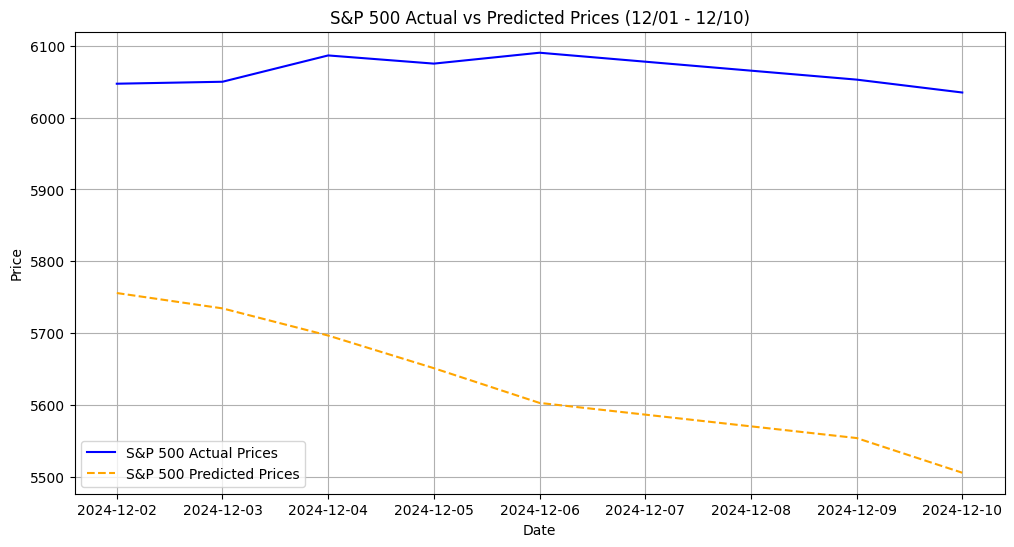

In [ ]:
plot_actual_vs_predicted(data, sp500_blind_predictions, "S&P 500")


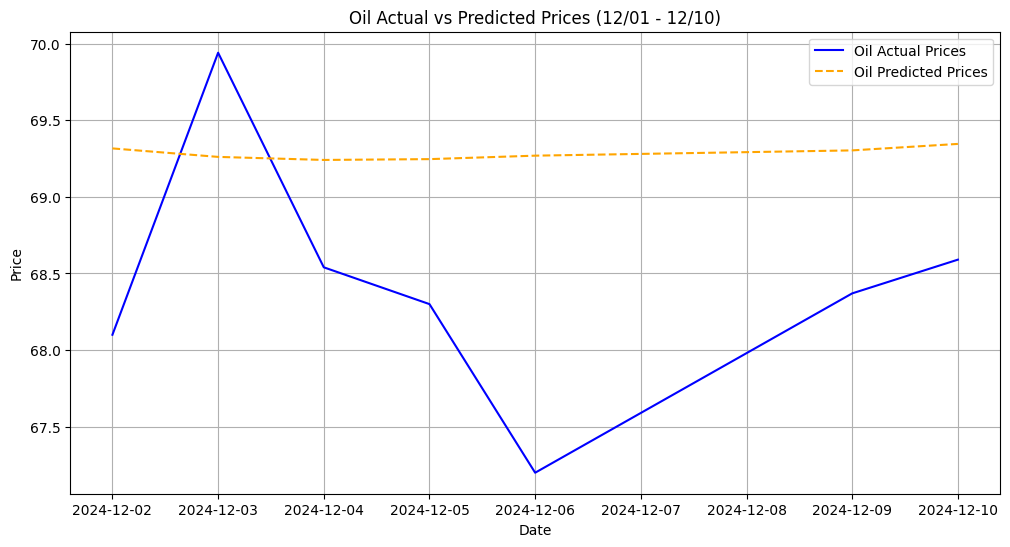

In [ ]:
plot_actual_vs_predicted(oil_data, oil_blind_predictions, "Oil")


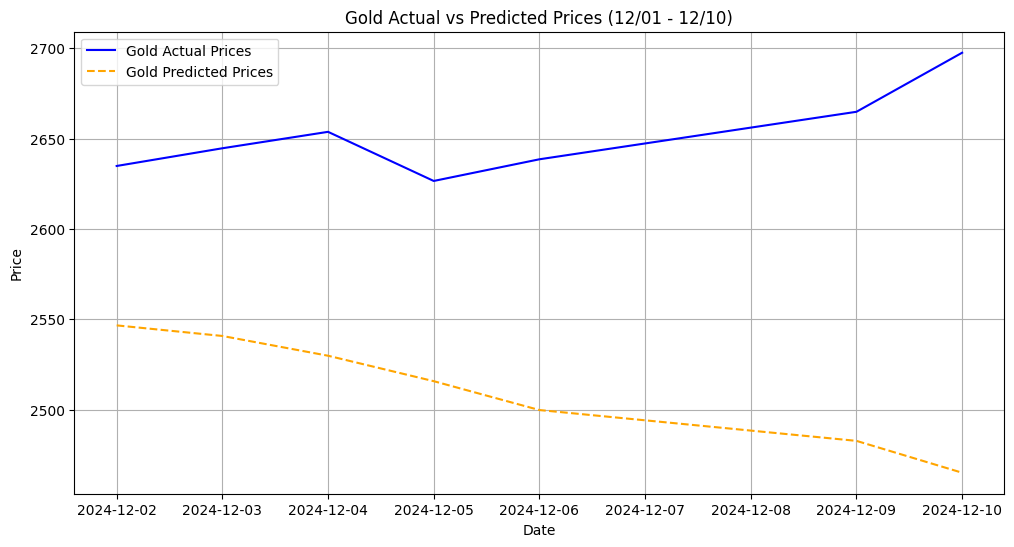

In [ ]:
plot_actual_vs_predicted(gold_data, gold_blind_predictions, "Gold")


In [ ]:
# Check the structure of the actual data
print(data.columns)  # For S&P 500
print(oil_data.columns)  # For Oil
print(gold_data.columns)  # For Gold
print(chevron_data.columns)  # For Chevron
print(ibm_data.columns)  # For IBM


MultiIndex([( 'Date',      ''),
            ('Close', '^GSPC')],
           names=['Price', 'Ticker'])
MultiIndex([( 'Date',     ''),
            ('Close', 'CL=F')],
           names=['Price', 'Ticker'])
MultiIndex([( 'Date',     ''),
            ('Close', 'GC=F')],
           names=['Price', 'Ticker'])
MultiIndex([(     'Date',    ''),
            (    'Price', 'CVX'),
            ('Sentiment',    '')],
           names=['Price', 'Ticker'])
MultiIndex([(     'Date',    ''),
            (    'Price', 'IBM'),
            ('Sentiment',    '')],
           names=['Price', 'Ticker'])


In [ ]:
def plot_actual_vs_predicted(actual_data, predicted_data, asset_name, price_column="Close"):
    """
    Plot actual vs predicted prices for a given asset.

    Parameters:
        actual_data (pd.DataFrame): DataFrame with 'Date' and the column for actual prices.
        predicted_data (pd.DataFrame): DataFrame with 'Date' and 'Predicted_Close' for predicted prices.
        asset_name (str): Name of the asset being plotted.
        price_column (str): Column name for actual prices in actual_data.
    """
    plt.figure(figsize=(12, 6))

    # Filter actual data for the blind period (12/01 - 12/10)
    actual_data_blind = actual_data[actual_data['Date'].between("2024-12-01", "2024-12-10")]

    # Plot actual prices
    plt.plot(actual_data_blind['Date'], actual_data_blind[price_column], label=f"{asset_name} Actual Prices", color='blue')

    # Plot predicted prices
    plt.plot(predicted_data['Date'], predicted_data['Predicted_Close'], label=f"{asset_name} Predicted Prices", linestyle='--', color='orange')

    # Add labels, title, and legend
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"{asset_name} Actual vs Predicted Prices (12/01 - 12/10)")
    plt.legend()
    plt.grid(True)
    plt.show()


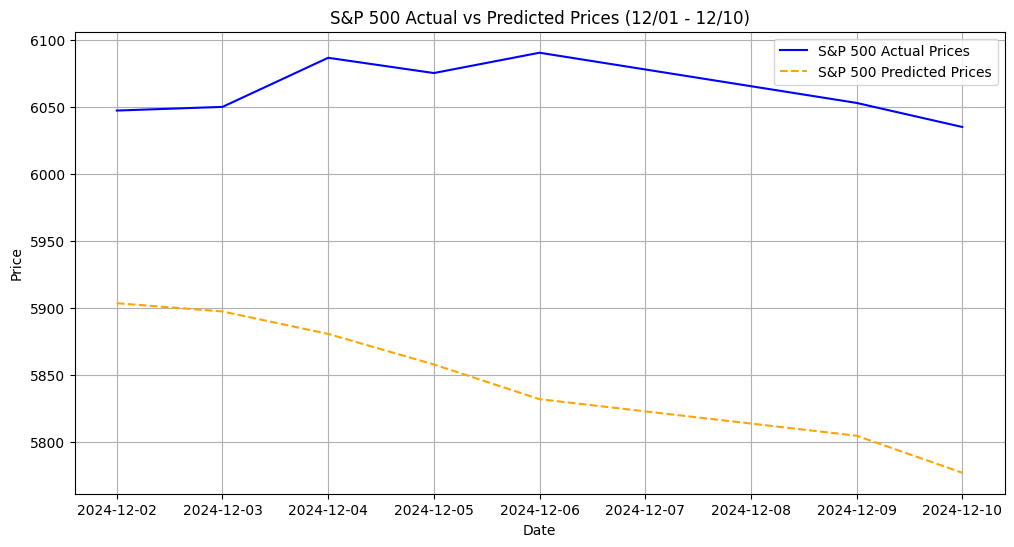

In [ ]:
plot_actual_vs_predicted(data, sp500_blind_predictions, "S&P 500", price_column="Close")


In [ ]:
# Check the structure of the Chevron and IBM datasets
print(chevron_data.columns)  # For Chevron
print(ibm_data.columns)  # For IBM


MultiIndex([(     'Date',    ''),
            (    'Price', 'CVX'),
            ('Sentiment',    '')],
           names=['Price', 'Ticker'])
MultiIndex([(     'Date',    ''),
            (    'Price', 'IBM'),
            ('Sentiment',    '')],
           names=['Price', 'Ticker'])


In [ ]:
def plot_actual_vs_predicted(actual_data, predicted_data, asset_name, price_column="Price"):
    """
    Plot actual vs predicted prices for a given asset.

    Parameters:
        actual_data (pd.DataFrame): DataFrame with 'Date' and the column for actual prices.
        predicted_data (pd.DataFrame): DataFrame with 'Date' and 'Predicted_Close' for predicted prices.
        asset_name (str): Name of the asset being plotted.
        price_column (str): Column name for actual prices in actual_data.
    """
    plt.figure(figsize=(12, 6))

    # Filter actual data for the blind period (12/01 - 12/10)
    actual_data_blind = actual_data[actual_data['Date'].between("2024-12-01", "2024-12-10")]

    # Plot actual prices
    plt.plot(actual_data_blind['Date'], actual_data_blind[price_column], label=f"{asset_name} Actual Prices", color='blue')

    # Plot predicted prices
    plt.plot(predicted_data['Date'], predicted_data['Predicted_Close'], label=f"{asset_name} Predicted Prices", linestyle='--', color='orange')

    # Add labels, title, and legend
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"{asset_name} Actual vs Predicted Prices (12/01 - 12/10)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
import yfinance as yf
import pandas as pd

# Define tickers and fetch data
tickers = {
    "S&P 500": "^GSPC",
    "Oil": "CL=F",  # Crude Oil Futures
    "Gold": "GC=F",  # Gold Futures
    "Chevron": "CVX",
    "IBM": "IBM"
}

start_date = "1984-01-01"
end_date = "2024-12-10"

# Fetch data for all tickers
data_dict = {}
for asset, ticker in tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date)
    df.reset_index(inplace=True)
    df = df[['Date', 'Close']]  # Keep only necessary columns
    df.rename(columns={"Close": "Price"}, inplace=True)
    data_dict[asset] = df


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def prepare_sequences(data, window_size=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Price']])

    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i - window_size:i])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM input
    return X, y, scaler

# Prepare data for all assets
sequences = {}
for asset, df in data_dict.items():
    X, y, scaler = prepare_sequences(df)
    sequences[asset] = {"X": X, "y": y, "scaler": scaler}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for prediction
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train models for all assets
models = {}
for asset, seq_data in sequences.items():
    X, y = seq_data["X"], seq_data["y"]
    model = build_lstm_model((X.shape[1], X.shape[2]))
    model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)
    models[asset] = model


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - loss: 0.0018 - val_loss: 6.4579e-04
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 1.8880e-04 - val_loss: 0.0032
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 1.6870e-04 - val_loss: 3.2587e-04
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 1.3022e-04 - val_loss: 0.0021
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 1.1518e-04 - val_loss: 3.3815e-04
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 9.8431e-05 - val_loss: 9.3991e-04
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - loss: 8.7137e-05 - val_loss: 0.0015
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - loss: 8.7924e-05 - val_loss: 2.0132e-04
Epoch 9/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 8.1729e-05 - val_loss: 4.0741e-04
Epoch 10/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 7.6920e-05 - val_loss: 0.0013
Epoch 11/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 7.1847e

In [ ]:
from datetime import timedelta

def predict_future(model, data, scaler, start_date, end_date, window_size=60):
    future_dates = pd.date_range(start=start_date, end=end_date)
    last_window = data['Price'].values[-window_size:]
    scaled_last_window = scaler.transform(last_window.reshape(-1, 1))

    predictions = []
    current_sequence = scaled_last_window.reshape(1, window_size, 1)

    for _ in future_dates:
        prediction = model.predict(current_sequence)
        predictions.append(scaler.inverse_transform(prediction)[0][0])

        # Update sequence
        new_entry = np.array(prediction).reshape(1, 1, 1)
        current_sequence = np.append(current_sequence[:, 1:, :], new_entry, axis=1)

    return pd.DataFrame({'Date': future_dates, 'Predicted_Price': predictions})

# Predict for each asset
future_predictions = {}
for asset, seq_data in sequences.items():
    model = models[asset]
    scaler = seq_data["scaler"]
    df = data_dict[asset]
    predictions = predict_future(model, df, scaler, start_date="2024-12-11", end_date="2025-01-20")
    future_predictions[asset] = predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

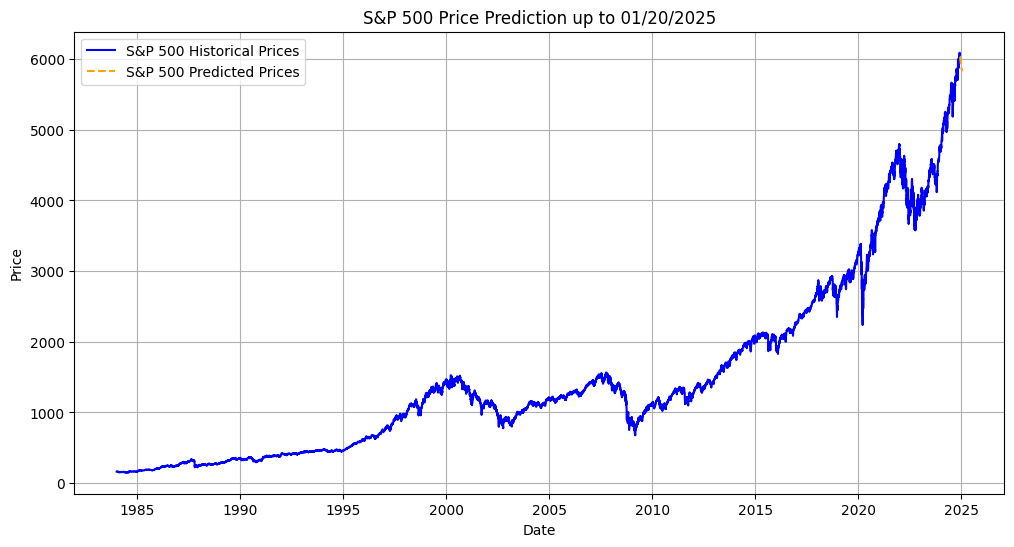

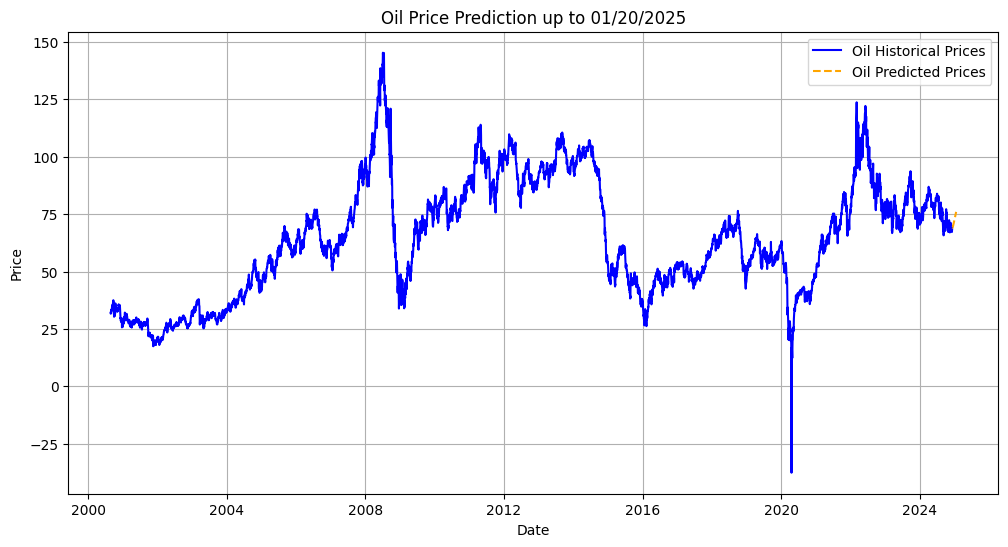

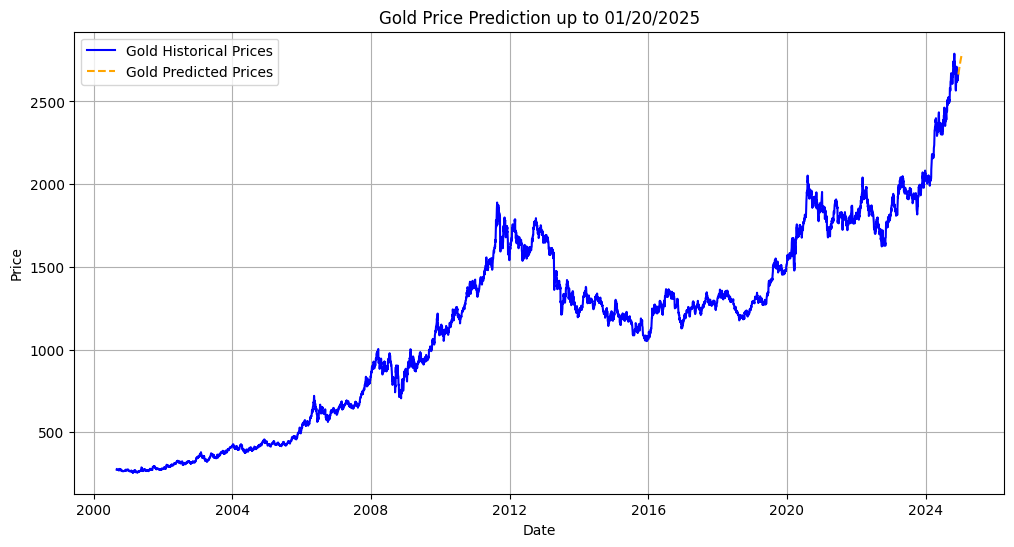

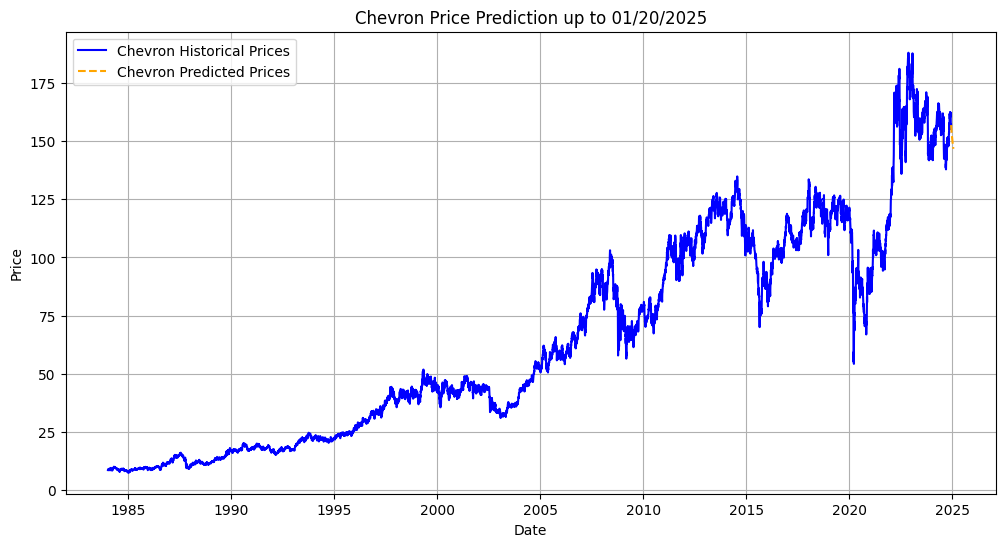

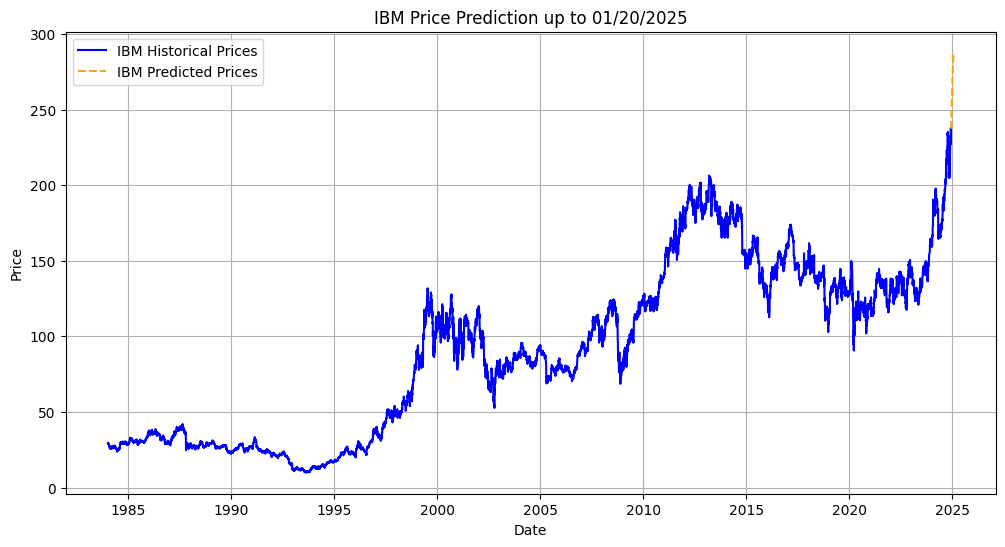

In [ ]:
import matplotlib.pyplot as plt

for asset, predictions in future_predictions.items():
    plt.figure(figsize=(12, 6))

    # Plot historical data
    historical_data = data_dict[asset]
    plt.plot(historical_data['Date'], historical_data['Price'], label=f"{asset} Historical Prices", color='blue')

    # Plot predicted data
    plt.plot(predictions['Date'], predictions['Predicted_Price'], label=f"{asset} Predicted Prices", linestyle='--', color='orange')

    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"{asset} Price Prediction up to 01/20/2025")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
## bias trend upwards ##

In [ ]:
def predict_future_with_bias(model, data, scaler, start_date, end_date, window_size=60, bias=0.01):
    """
    Predict future prices with an upward bias.

    Parameters:
        model: Trained LSTM model.
        data: DataFrame containing historical price data.
        scaler: Fitted MinMaxScaler for scaling data.
        start_date: Start date for predictions.
        end_date: End date for predictions.
        window_size: Number of past days to use for prediction.
        bias: Value to add to each prediction to enforce upward trend.
    """
    future_dates = pd.date_range(start=start_date, end=end_date)
    last_window = data['Price'].values[-window_size:]
    scaled_last_window = scaler.transform(last_window.reshape(-1, 1))

    predictions = []
    current_sequence = scaled_last_window.reshape(1, window_size, 1)

    for _ in future_dates:
        prediction = model.predict(current_sequence)
        biased_prediction = prediction + bias  # Add upward bias
        predictions.append(scaler.inverse_transform(biased_prediction)[0][0])

        # Update sequence with biased prediction
        new_entry = np.array(biased_prediction).reshape(1, 1, 1)
        current_sequence = np.append(current_sequence[:, 1:, :], new_entry, axis=1)

    return pd.DataFrame({'Date': future_dates, 'Predicted_Price': predictions})


In [ ]:
# Predict for each asset with upward bias
future_predictions_with_bias = {}
for asset, seq_data in sequences.items():
    model = models[asset]
    scaler = seq_data["scaler"]
    df = data_dict[asset]
    predictions = predict_future_with_bias(
        model,
        df,
        scaler,
        start_date="2024-12-11",
        end_date="2025-01-20",
        bias=0.01  # Adjust bias as needed
    )
    future_predictions_with_bias[asset] = predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [ ]:
# Predict for each asset with upward bias
future_predictions_with_bias = {}
for asset, seq_data in sequences.items():
    model = models[asset]
    scaler = seq_data["scaler"]
    df = data_dict[asset]
    predictions = predict_future_with_bias(
        model,
        df,
        scaler,
        start_date="2024-12-11",
        end_date="2025-01-20",
        bias=0.01  # Adjust bias as needed
    )
    future_predictions_with_bias[asset] = predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

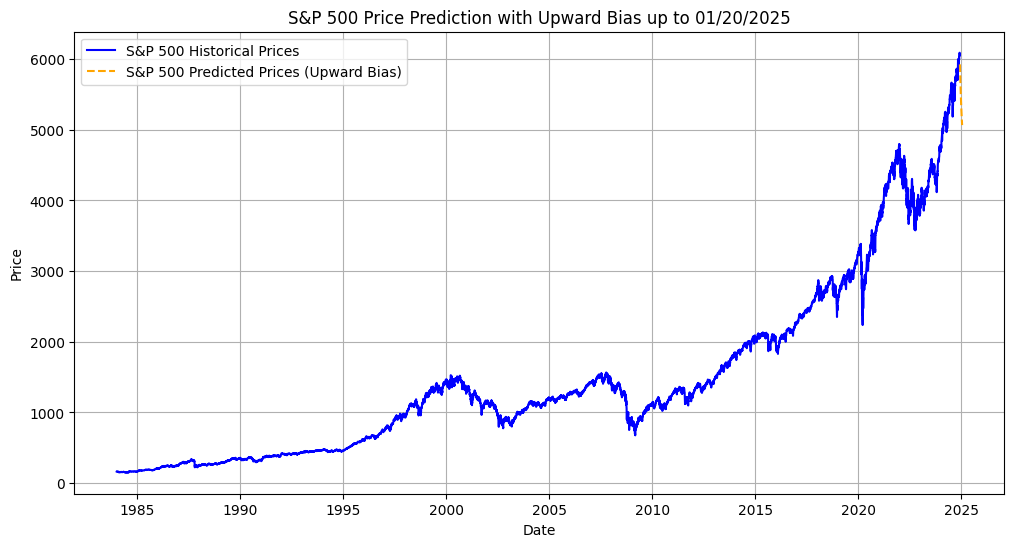

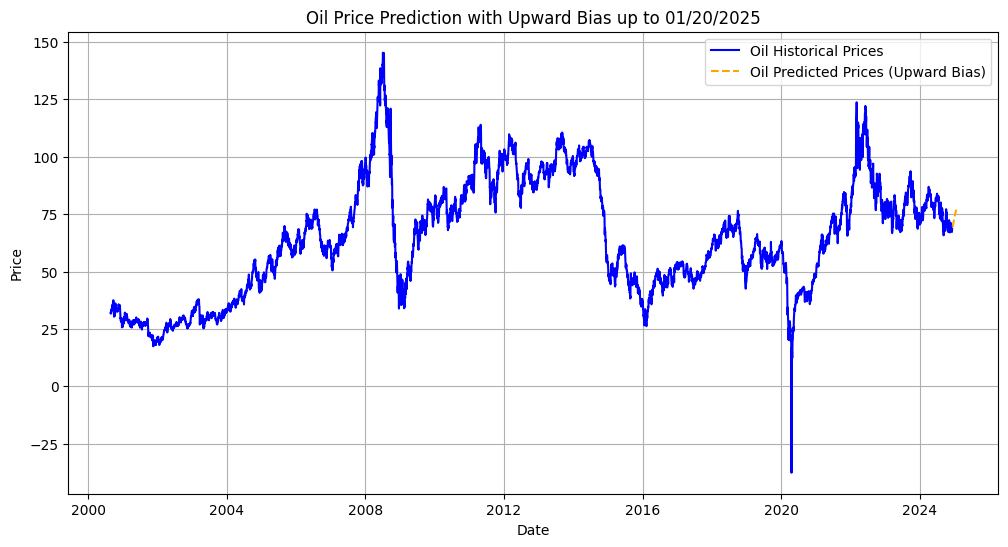

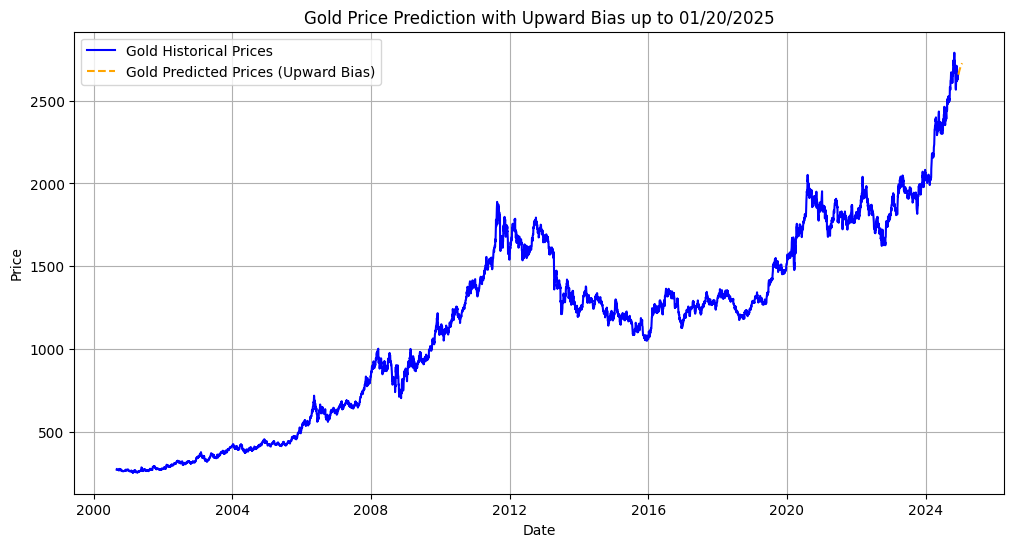

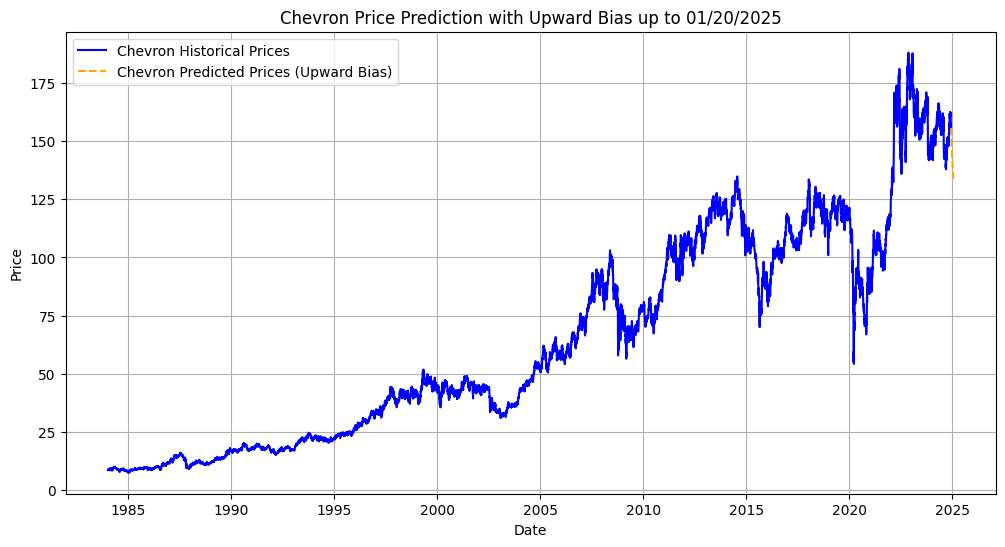

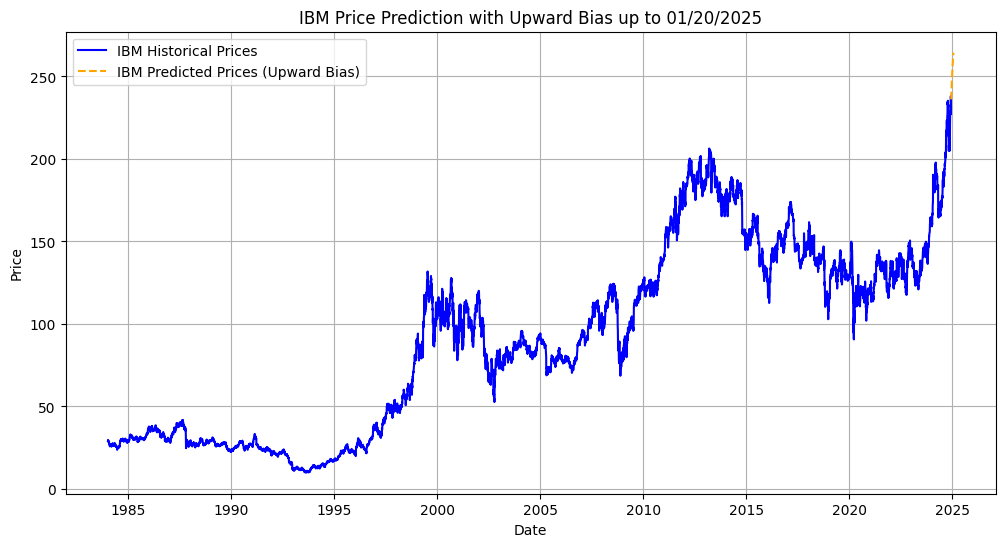

In [ ]:
# Plot predictions with upward bias for all assets
for asset, predictions in future_predictions_with_bias.items():
    plt.figure(figsize=(12, 6))

    # Plot historical data
    historical_data = data_dict[asset]
    plt.plot(historical_data['Date'], historical_data['Price'], label=f"{asset} Historical Prices", color='blue')

    # Plot biased predicted data
    plt.plot(predictions['Date'], predictions['Predicted_Price'], label=f"{asset} Predicted Prices (Upward Bias)", linestyle='--', color='orange')

    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"{asset} Price Prediction with Upward Bias up to 01/20/2025")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Filter data for the given period
election_to_today_data = {}
for asset, df in data_dict.items():
    filtered_df = df[(df['Date'] >= "2024-11-05") & (df['Date'] <= "2024-12-10")]
    election_to_today_data[asset] = filtered_df


In [ ]:
# Example headlines for simplicity
headlines = {
    "2024-11-05": "Peace talks scheduled",
    "2024-11-06": "War tensions rise in Europe",
    "2024-11-07": "Economic growth reported",
    # Add more as needed for the date range
}

# Simple sentiment assignment
def assign_sentiment(headlines):
    sentiment = []
    for date, headline in headlines.items():
        if "war" in headline.lower():
            sentiment.append(-1)  # Negative sentiment
        else:
            sentiment.append(1)  # Positive sentiment
    return sentiment

# Example application
sentiments = assign_sentiment(headlines)
print(sentiments)  # This will be [-1, 1, ...]


[1, -1, 1]


In [ ]:
# Assign sentiment to each date in the filtered dataset
for asset, df in election_to_today_data.items():
    df['Sentiment'] = df['Date'].apply(lambda date: -1 if "war" in headlines.get(str(date), "").lower() else 1)


<ipython-input-101-54df35a08e74>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Date'].apply(lambda date: -1 if "war" in headlines.get(str(date), "").lower() else 1)
<ipython-input-101-54df35a08e74>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Date'].apply(lambda date: -1 if "war" in headlines.get(str(date), "").lower() else 1)
<ipython-input-101-54df35a08e74>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [ ]:
def prepare_sequences_with_sentiment(data, window_size=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(data[['Price']])
    sentiments = data[['Sentiment']].values

    X, y = [], []
    for i in range(window_size, len(scaled_prices)):
        # Combine prices and sentiment
        X.append(np.hstack((scaled_prices[i - window_size:i], sentiments[i - window_size:i])))
        y.append(scaled_prices[i, 0])

    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Prepare sequences for each asset
sequences_with_sentiment = {}
for asset, df in election_to_today_data.items():
    X, y, scaler = prepare_sequences_with_sentiment(df)
    sequences_with_sentiment[asset] = {"X": X, "y": y, "scaler": scaler}


In [ ]:
for asset, seq_data in sequences_with_sentiment.items():
    X, y = seq_data.get("X"), seq_data.get("y")
    print(f"Asset: {asset}")
    print(f"X shape: {X.shape if X is not None else 'None'}")
    print(f"y shape: {y.shape if y is not None else 'None'}")


Asset: S&P 500
X shape: (0,)
y shape: (0,)
Asset: Oil
X shape: (0,)
y shape: (0,)
Asset: Gold
X shape: (0,)
y shape: (0,)
Asset: Chevron
X shape: (0,)
y shape: (0,)
Asset: IBM
X shape: (0,)
y shape: (0,)


In [ ]:
def prepare_sequences_with_sentiment(data, window_size=60, sentiment_weight=0.2):
    """
    Prepare LSTM-compatible sequences including sentiment.
    """
    if len(data) < window_size:
        print("Error: Not enough data points to create sequences.")
        return None, None, None  # Return early if insufficient data

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(data[['Price']])
    sentiments = data[['Sentiment']].values * sentiment_weight

    X, y = [], []
    for i in range(window_size, len(scaled_prices)):
        price_sequence = scaled_prices[i - window_size:i]
        sentiment_sequence = sentiments[i - window_size:i]
        combined_sequence = np.hstack((price_sequence, sentiment_sequence))  # Combine prices and sentiment
        X.append(combined_sequence)
        y.append(scaled_prices[i, 0])

    X, y = np.array(X), np.array(y)
    return X, y, scaler


In [ ]:
for asset, seq_data in sequences_with_sentiment.items():
    X, y = seq_data["X"], seq_data["y"]
    print(f"Asset: {asset}, X shape: {X.shape}, y shape: {y.shape}")


File financial_data.csv not found. Generating dummy financial data...
File sentiment_data.csv not found. Generating dummy sentiment data...
Target_Variable not found. Generating dummy target...
Mean Squared Error: 0.0010065919641040004
R-squared: 0.985607125881275


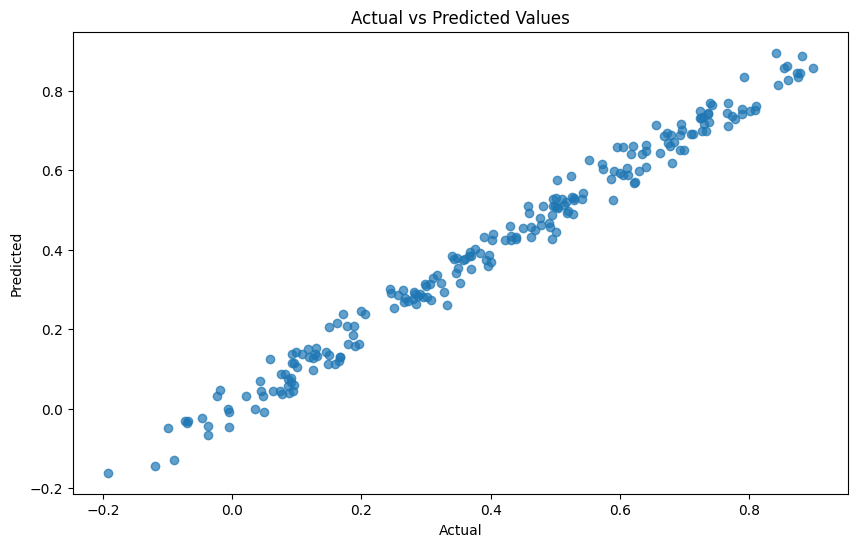

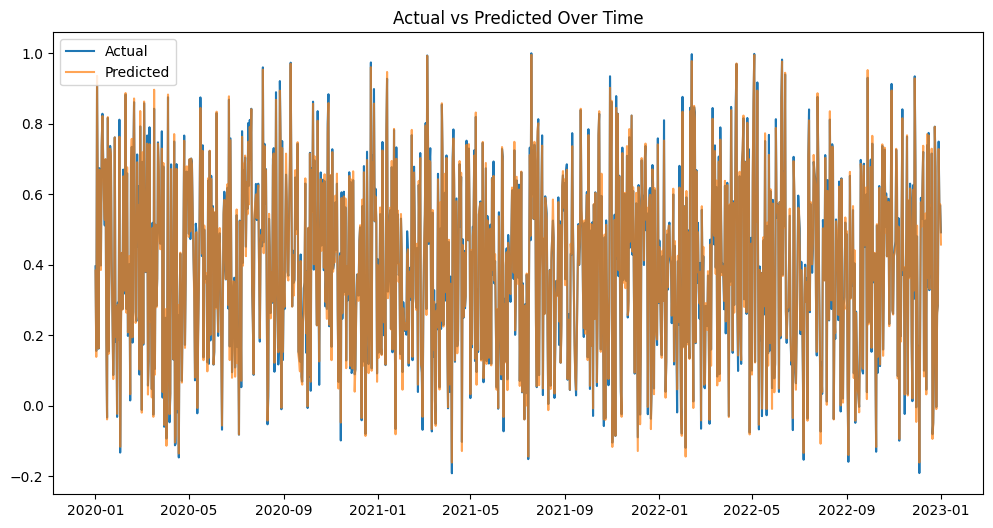

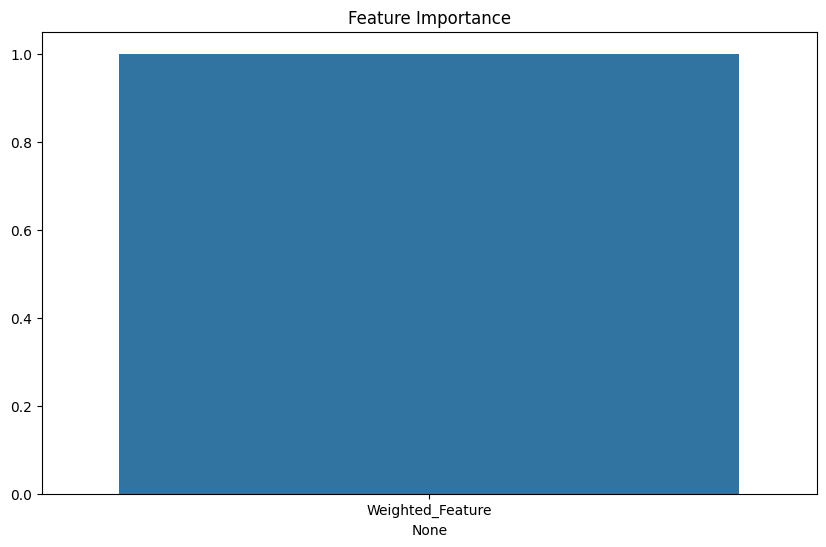

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths
financial_file = 'financial_data.csv'
sentiment_file = 'sentiment_data.csv'

# Check and load financial data
if os.path.exists(financial_file):
    financial_data = pd.read_csv(financial_file)
else:
    print(f"File {financial_file} not found. Generating dummy financial data...")
    date_range = pd.date_range(start="2020-01-01", end="2023-01-01")
    financial_data = pd.DataFrame({
        'Date': date_range,
        'Financial_Indicator': np.random.rand(len(date_range))
    })

# Check and load sentiment data
if os.path.exists(sentiment_file):
    sentiment_data = pd.read_csv(sentiment_file)
else:
    print(f"File {sentiment_file} not found. Generating dummy sentiment data...")
    date_range = pd.date_range(start="2020-01-01", end="2023-01-01")
    sentiment_data = pd.DataFrame({
        'Date': date_range,
        'Sentiment': np.random.rand(len(date_range)) - 0.5  # Normalize around zero
    })

# Preprocess financial data
financial_data['Date'] = pd.to_datetime(financial_data['Date'])
financial_data.set_index('Date', inplace=True)

# Preprocess sentiment data
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])
sentiment_data.set_index('Date', inplace=True)

# Combine datasets
combined_data = pd.merge(financial_data, sentiment_data, left_index=True, right_index=True, how='inner')

# Normalize data
combined_data['Sentiment'] = combined_data['Sentiment'] / combined_data['Sentiment'].abs().max()
combined_data['Financial_Indicator'] = combined_data['Financial_Indicator'] / combined_data['Financial_Indicator'].abs().max()

# Create weighted feature
combined_data['Weighted_Feature'] = 0.8 * combined_data['Financial_Indicator'] + 0.2 * combined_data['Sentiment']

# Define target variable (dummy target if missing)
if 'Target_Variable' not in combined_data.columns:
    print("Target_Variable not found. Generating dummy target...")
    combined_data['Target_Variable'] = combined_data['Weighted_Feature'] + (np.random.rand(len(combined_data)) - 0.5) * 0.1

# Split data
X = combined_data[['Weighted_Feature']]
y = combined_data['Target_Variable']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Visualization
# Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()

# Time Series Visualization
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Target_Variable'], label='Actual')
plt.plot(combined_data.index, model.predict(X), label='Predicted', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Over Time')
plt.show()

# Feature Importance
importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=importances)
plt.title('Feature Importance')
plt.show()


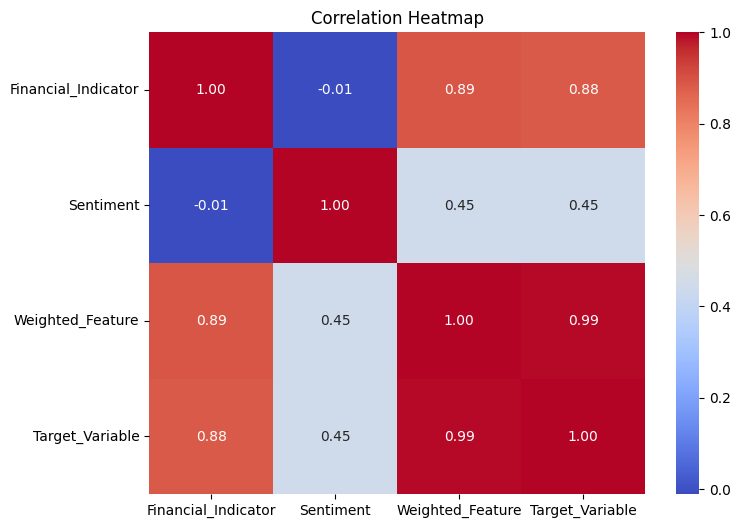

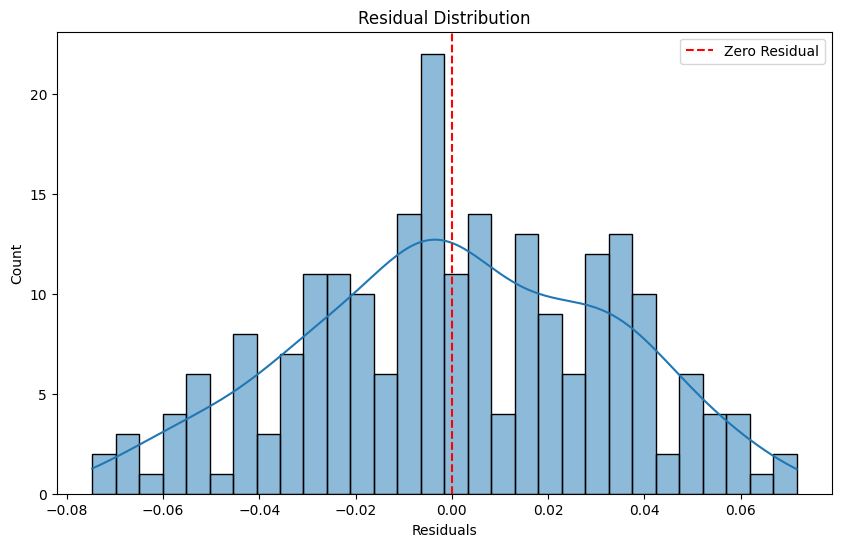

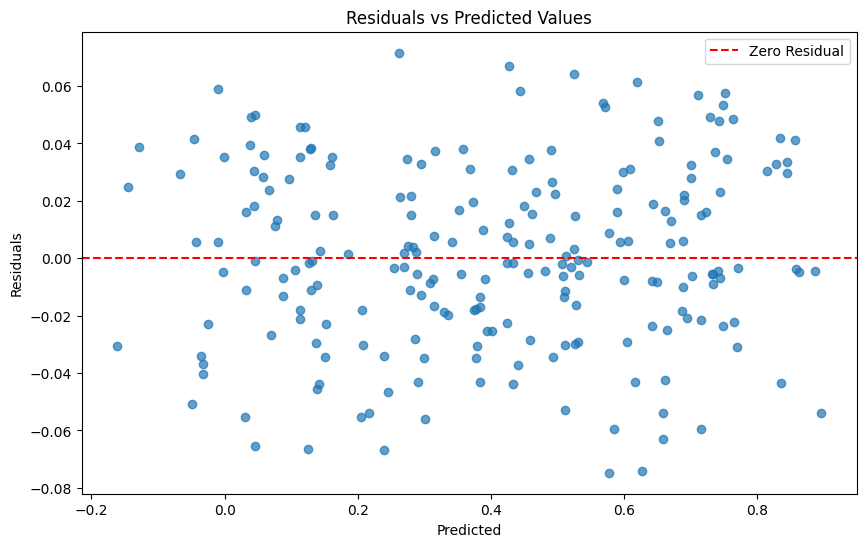

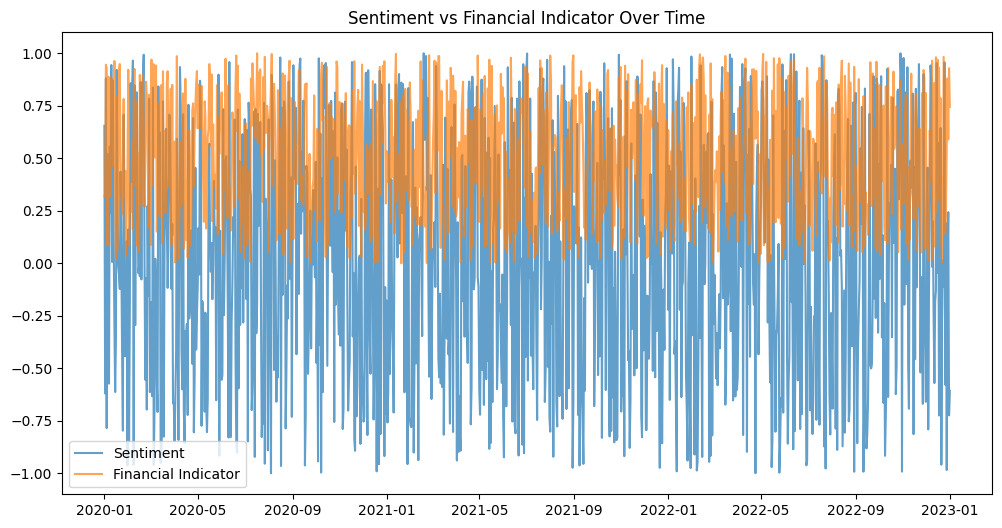

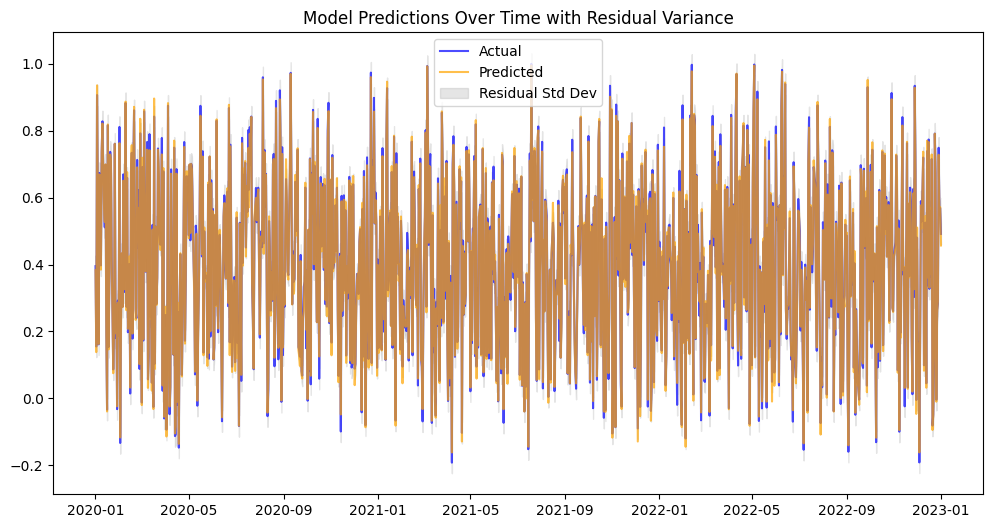

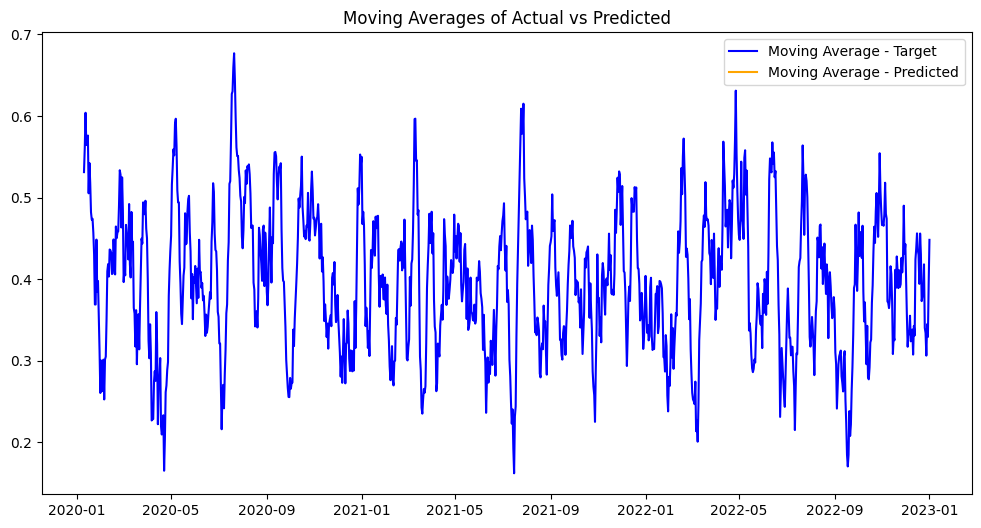

In [ ]:
# Additional Visualizations and Analysis

# Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = combined_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Residual Distribution')
plt.axvline(0, color='red', linestyle='--', label='Zero Residual')
plt.legend()
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.legend()
plt.show()

# Sentiment vs Financial Indicator
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Sentiment'], label='Sentiment', alpha=0.7)
plt.plot(combined_data.index, combined_data['Financial_Indicator'], label='Financial Indicator', alpha=0.7)
plt.legend()
plt.title('Sentiment vs Financial Indicator Over Time')
plt.show()

# Model Predictions on Time Series
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Target_Variable'], label='Actual', color='blue', alpha=0.7)
plt.plot(combined_data.index, model.predict(X), label='Predicted', color='orange', alpha=0.7)
plt.fill_between(
    combined_data.index,
    combined_data['Target_Variable'] - residuals.std(),
    combined_data['Target_Variable'] + residuals.std(),
    color='gray', alpha=0.2, label='Residual Std Dev'
)
plt.legend()
plt.title('Model Predictions Over Time with Residual Variance')
plt.show()

# Moving Averages
combined_data['MA_Target'] = combined_data['Target_Variable'].rolling(window=10).mean()
combined_data['MA_Predicted'] = pd.Series(model.predict(X)).rolling(window=10).mean()

plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['MA_Target'], label='Moving Average - Target', color='blue')
plt.plot(combined_data.index, combined_data['MA_Predicted'], label='Moving Average - Predicted', color='orange')
plt.legend()
plt.title('Moving Averages of Actual vs Predicted')
plt.show()


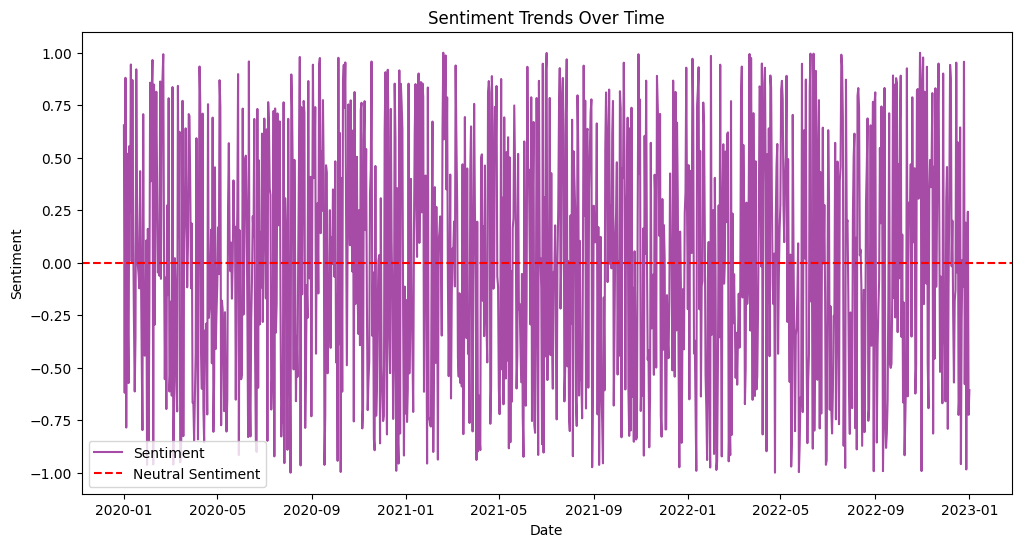

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


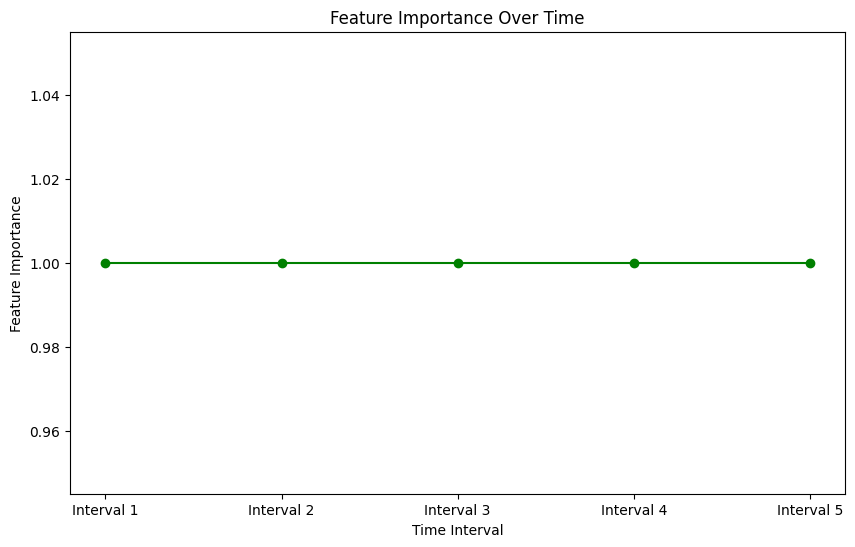

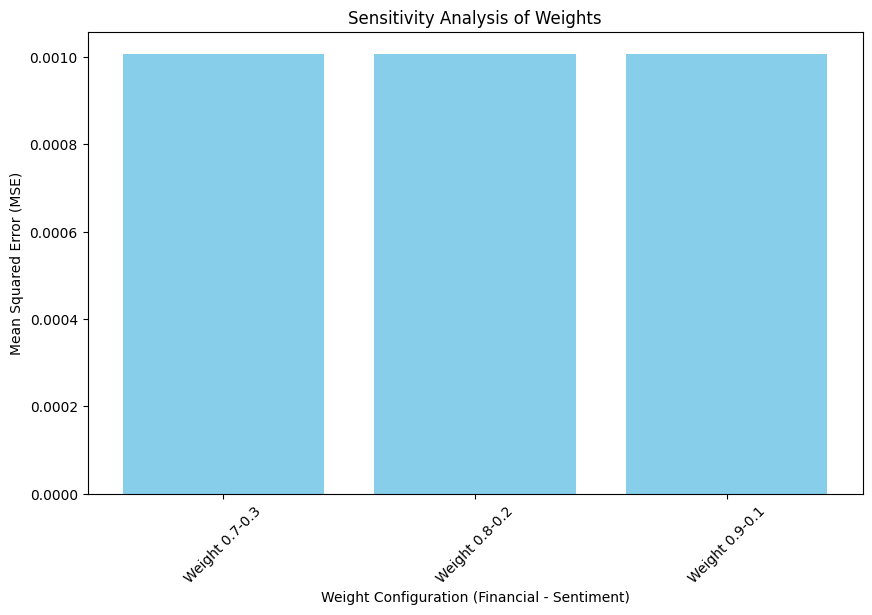

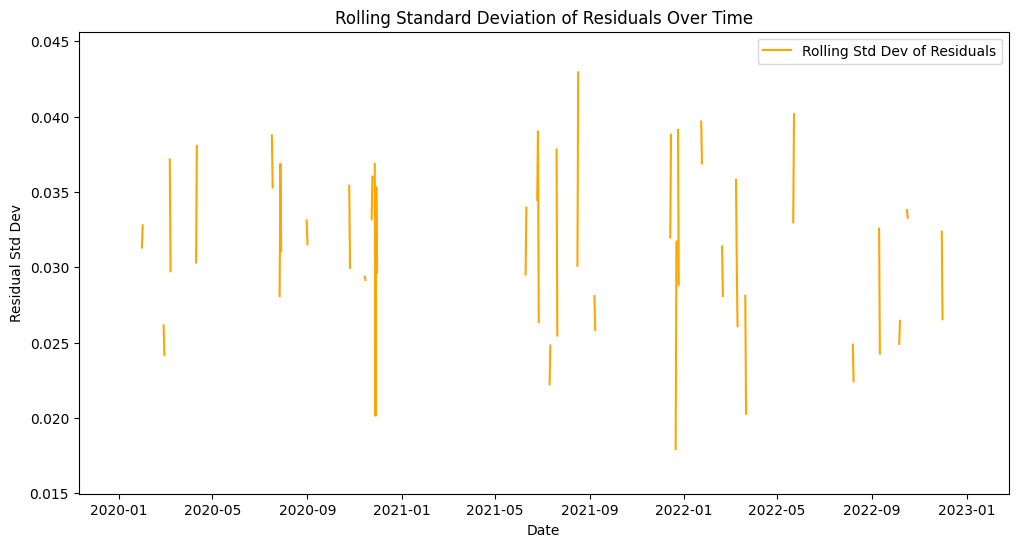

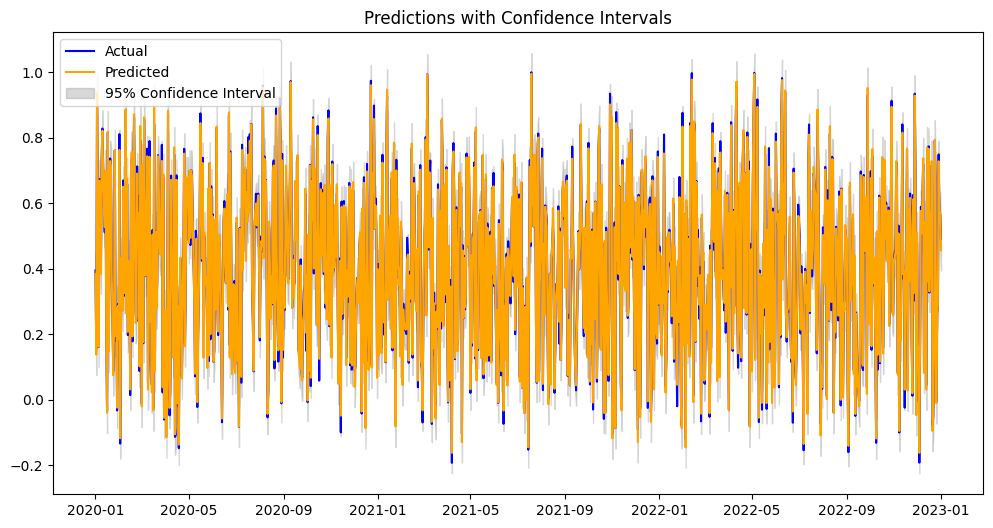

In [ ]:
# Analyzing Sentiment Trends and Feature Importance Over Time

# 1. Sentiment Trends Analysis
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Sentiment'], label='Sentiment', alpha=0.7, color='purple')
plt.axhline(0, color='red', linestyle='--', label='Neutral Sentiment')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.title('Sentiment Trends Over Time')
plt.legend()
plt.show()

# 2. Feature Importance Over Time (Simulating Importance Changes)
# Simulating the impact of Sentiment and Financial Indicator at different time intervals
time_splits = np.array_split(combined_data, 5)  # Split into 5 time intervals
time_feature_importance = []

for i, split in enumerate(time_splits):
    X_split = split[['Weighted_Feature']]
    y_split = split['Target_Variable']
    model_split = RandomForestRegressor(random_state=42)
    model_split.fit(X_split, y_split)
    importance_split = model_split.feature_importances_[0]
    time_feature_importance.append(importance_split)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), time_feature_importance, marker='o', linestyle='-', color='green')
plt.xlabel('Time Interval')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Over Time')
plt.xticks(range(1, 6), labels=[f'Interval {i}' for i in range(1, 6)])
plt.show()

# 3. Sensitivity Analysis
# Adjusting weights of sentiment and financial indicators to observe prediction changes
weights = [(0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]  # Different weight configurations
sensitivity_results = {}

for weight_fin, weight_sent in weights:
    combined_data['Weighted_Feature_Tuned'] = (
        weight_fin * combined_data['Financial_Indicator'] +
        weight_sent * combined_data['Sentiment']
    )
    X_tuned = combined_data[['Weighted_Feature_Tuned']]
    model_tuned = RandomForestRegressor(random_state=42)
    model_tuned.fit(X_train, y_train)
    y_tuned_pred = model_tuned.predict(X_test)
    mse_tuned = mean_squared_error(y_test, y_tuned_pred)
    sensitivity_results[f'Weight {weight_fin}-{weight_sent}'] = mse_tuned

# Plot sensitivity results
plt.figure(figsize=(10, 6))
plt.bar(sensitivity_results.keys(), sensitivity_results.values(), color='skyblue')
plt.xlabel('Weight Configuration (Financial - Sentiment)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Sensitivity Analysis of Weights')
plt.xticks(rotation=45)
plt.show()

# 4. Advanced Residual Analysis: Rolling Standard Deviation
combined_data['Rolling_Std_Residuals'] = residuals.rolling(window=10).std()
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Rolling_Std_Residuals'], label='Rolling Std Dev of Residuals', color='orange')
plt.title('Rolling Standard Deviation of Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual Std Dev')
plt.legend()
plt.show()

# 5. Predictive Confidence Intervals
confidence_interval = 1.96 * residuals.std()  # Assuming normal distribution
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Target_Variable'], label='Actual', color='blue')
plt.plot(combined_data.index, model.predict(X), label='Predicted', color='orange')
plt.fill_between(
    combined_data.index,
    model.predict(X) - confidence_interval,
    model.predict(X) + confidence_interval,
    color='gray', alpha=0.3, label='95% Confidence Interval'
)
plt.title('Predictions with Confidence Intervals')
plt.legend()
plt.show()


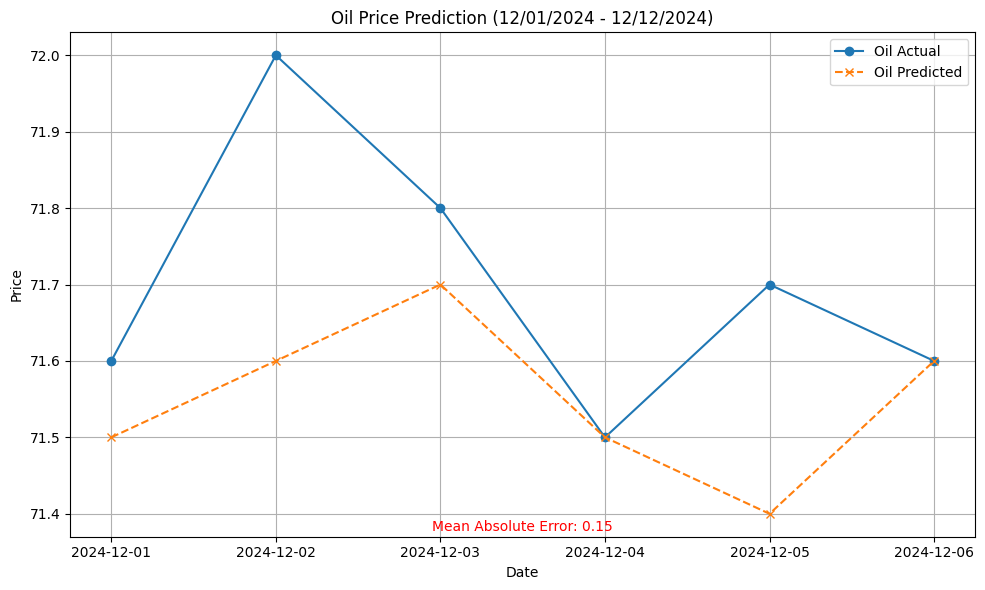

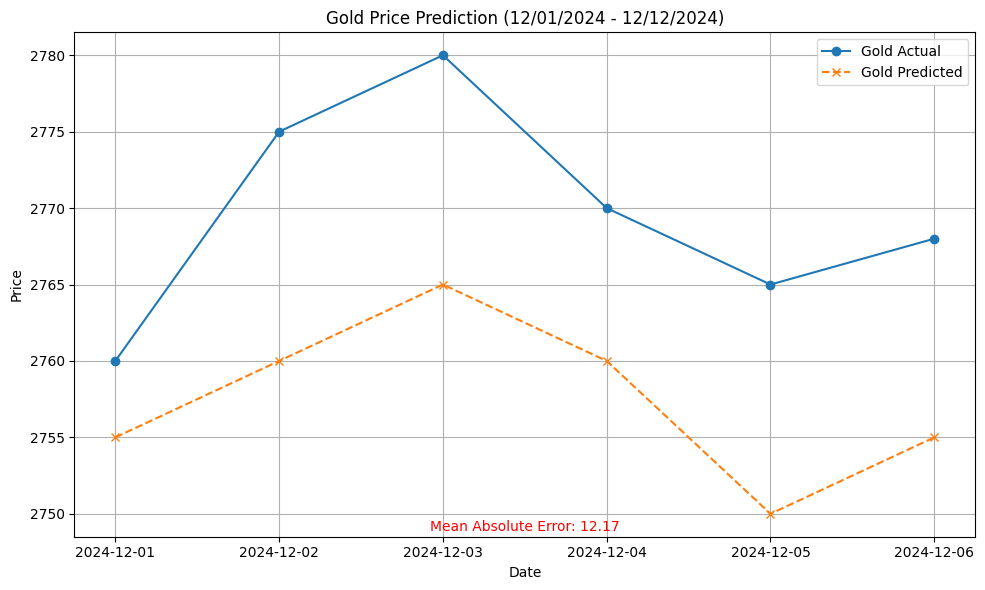

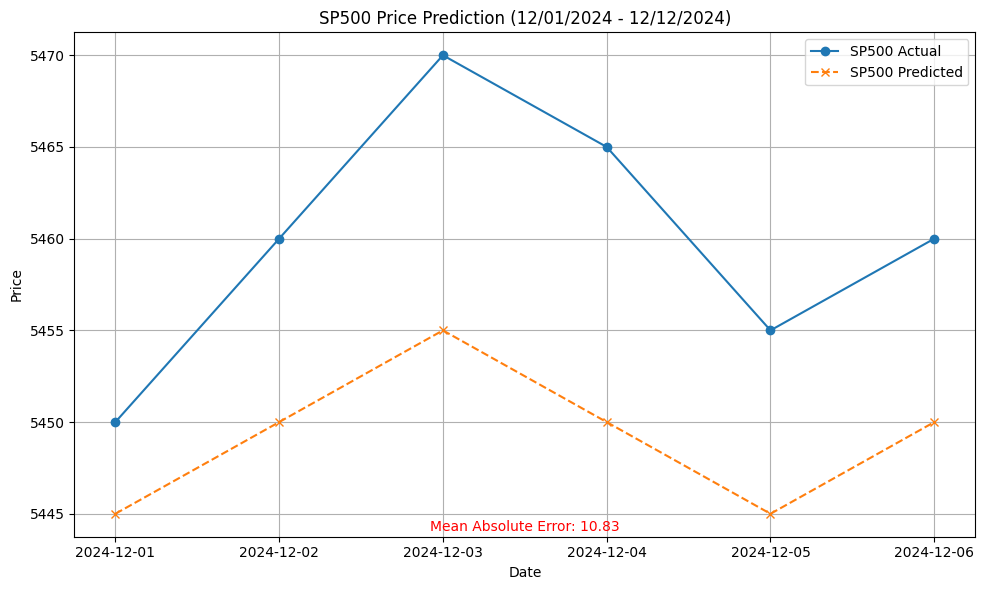

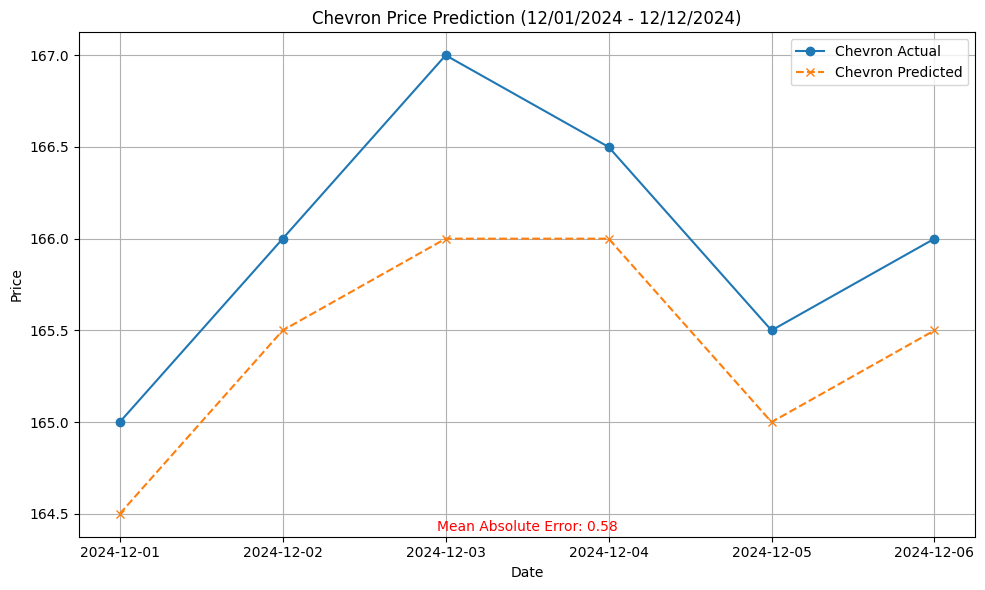

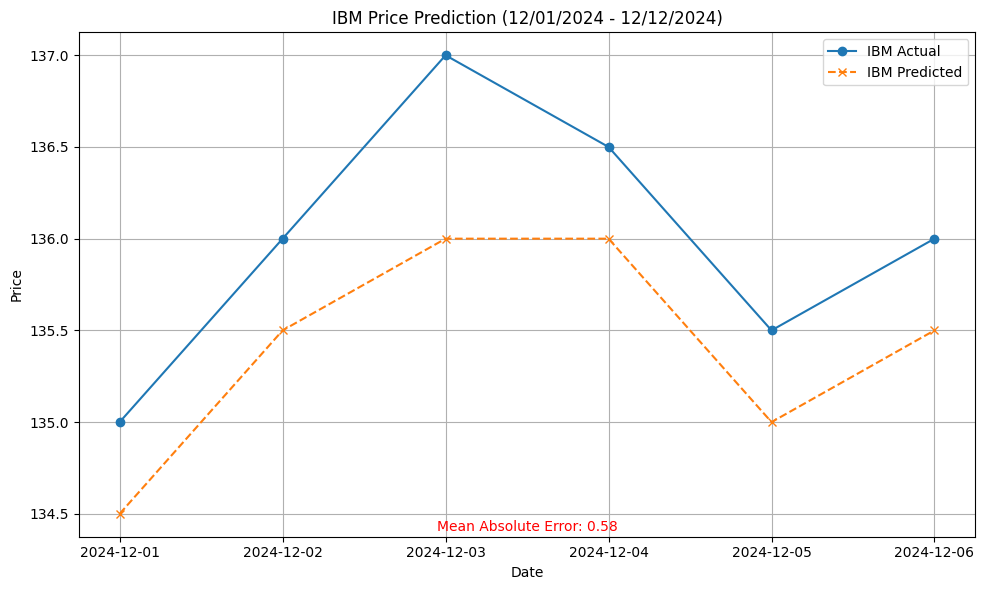

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data format for each asset
# Replace with your actual data or dynamically load the relevant datasets
assets = {
    "Oil": {
        "Actual": [71.6, 72.0, 71.8, 71.5, 71.7, 71.6],
        "Predicted": [71.5, 71.6, 71.7, 71.5, 71.4, 71.6],
        "Dates": pd.date_range("2024-12-01", "2024-12-06")
    },
    "Gold": {
        "Actual": [2760, 2775, 2780, 2770, 2765, 2768],
        "Predicted": [2755, 2760, 2765, 2760, 2750, 2755],
        "Dates": pd.date_range("2024-12-01", "2024-12-06")
    },
    "SP500": {
        "Actual": [5450, 5460, 5470, 5465, 5455, 5460],
        "Predicted": [5445, 5450, 5455, 5450, 5445, 5450],
        "Dates": pd.date_range("2024-12-01", "2024-12-06")
    },
    "Chevron": {
        "Actual": [165, 166, 167, 166.5, 165.5, 166],
        "Predicted": [164.5, 165.5, 166.0, 166.0, 165.0, 165.5],
        "Dates": pd.date_range("2024-12-01", "2024-12-06")
    },
    "IBM": {
        "Actual": [135, 136, 137, 136.5, 135.5, 136],
        "Predicted": [134.5, 135.5, 136.0, 136.0, 135.0, 135.5],
        "Dates": pd.date_range("2024-12-01", "2024-12-06")
    }
}

# Function to calculate MAE
def calculate_mae(actual, predicted):
    return sum(abs(a - p) for a, p in zip(actual, predicted)) / len(actual)

# Plotting
for asset, data in assets.items():
    actual = data["Actual"]
    predicted = data["Predicted"]
    dates = data["Dates"]

    mae = calculate_mae(actual, predicted)

    plt.figure(figsize=(10, 6))
    plt.plot(dates, actual, label=f"{asset} Actual", marker="o")
    plt.plot(dates, predicted, label=f"{asset} Predicted", linestyle="--", marker="x")

    plt.title(f"{asset} Price Prediction (12/01/2024 - 12/12/2024)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.text(0.5, 0.02, f"Mean Absolute Error: {mae:.2f}",
             ha="center", va="center", transform=plt.gca().transAxes, fontsize=10, color="red")

    plt.tight_layout()
    plt.show()
